# Titanic Survival Prediction using Random Forest

## Introduction
This kernel demonstrates the steps to preprocess the data, engineer new features, handle missing values, and apply machine learning techniques to predict the survival of Titanic passengers. We use a Random Forest classifier and evaluate its performance using various metrics and cross-validation techniques.

## 1. Data Loading and Initial Analysis
We start by loading the necessary packages and the dataset, then conduct an initial analysis to understand the data structure and identify missing values.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold,learning_curve
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from imblearn.combine import SMOTETomek
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import string

#for Age forecast
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor


# Suppress warnings
warnings.filterwarnings('ignore')


# Set plot style for seaborn
sns.set(style="whitegrid")

print('Packages were loaded')


train = pd.read_csv('/kaggle/input/2024-sce-ml-course/train_2022.csv')
test = pd.read_csv('/kaggle/input/2024-sce-ml-course/test_2022.csv')

print(train.info())
print("-"*100)
print(test.info())




Packages were loaded
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    object 
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB
None
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column 

### Visualizing Data Characteristics
We visualize the data to understand its structure, identify missing values, and observe feature distributions and correlations.
#### Graphs are ploted by q:
1. Missing Values Distribution
1. Histograms of Numerical Features
1. Feature Correlation Matrix
1. Summary Statistics of Numerical Features
1. Categorical Feature Distribution



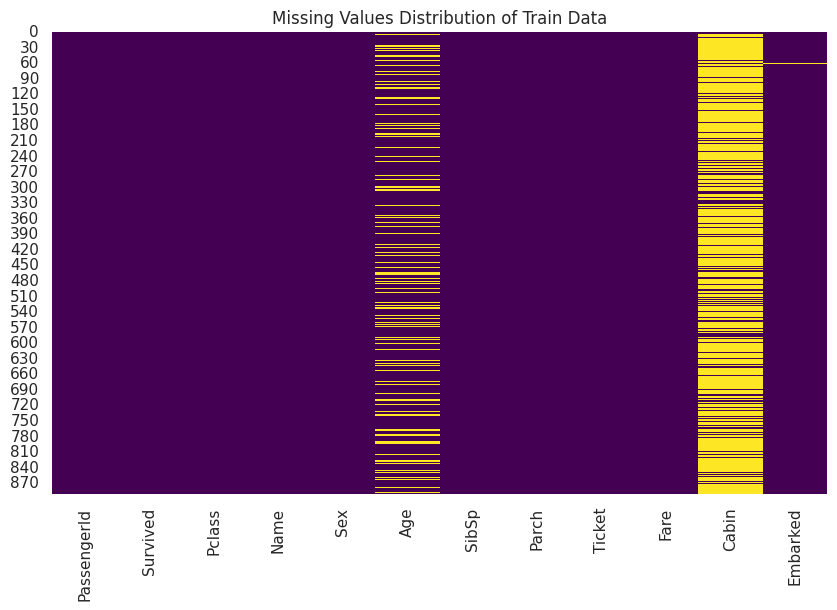

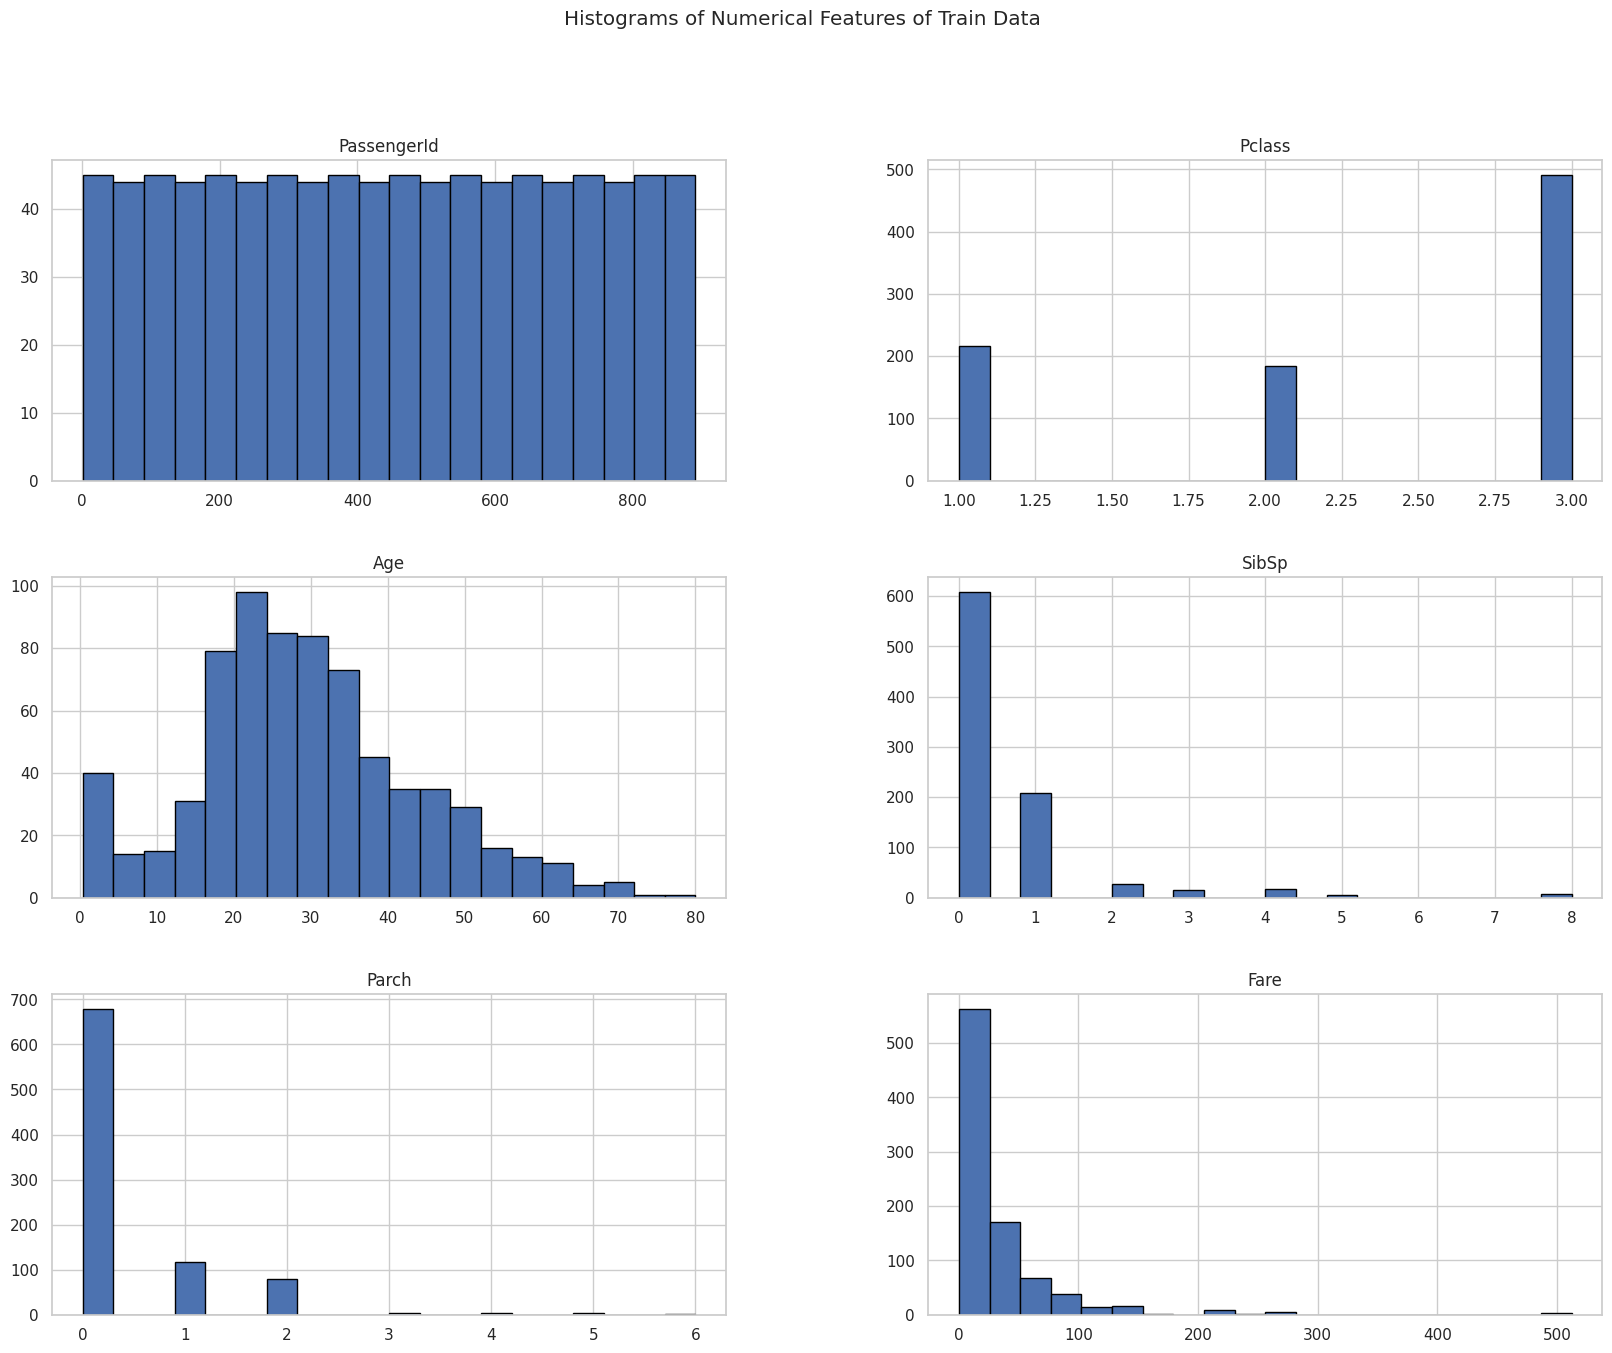

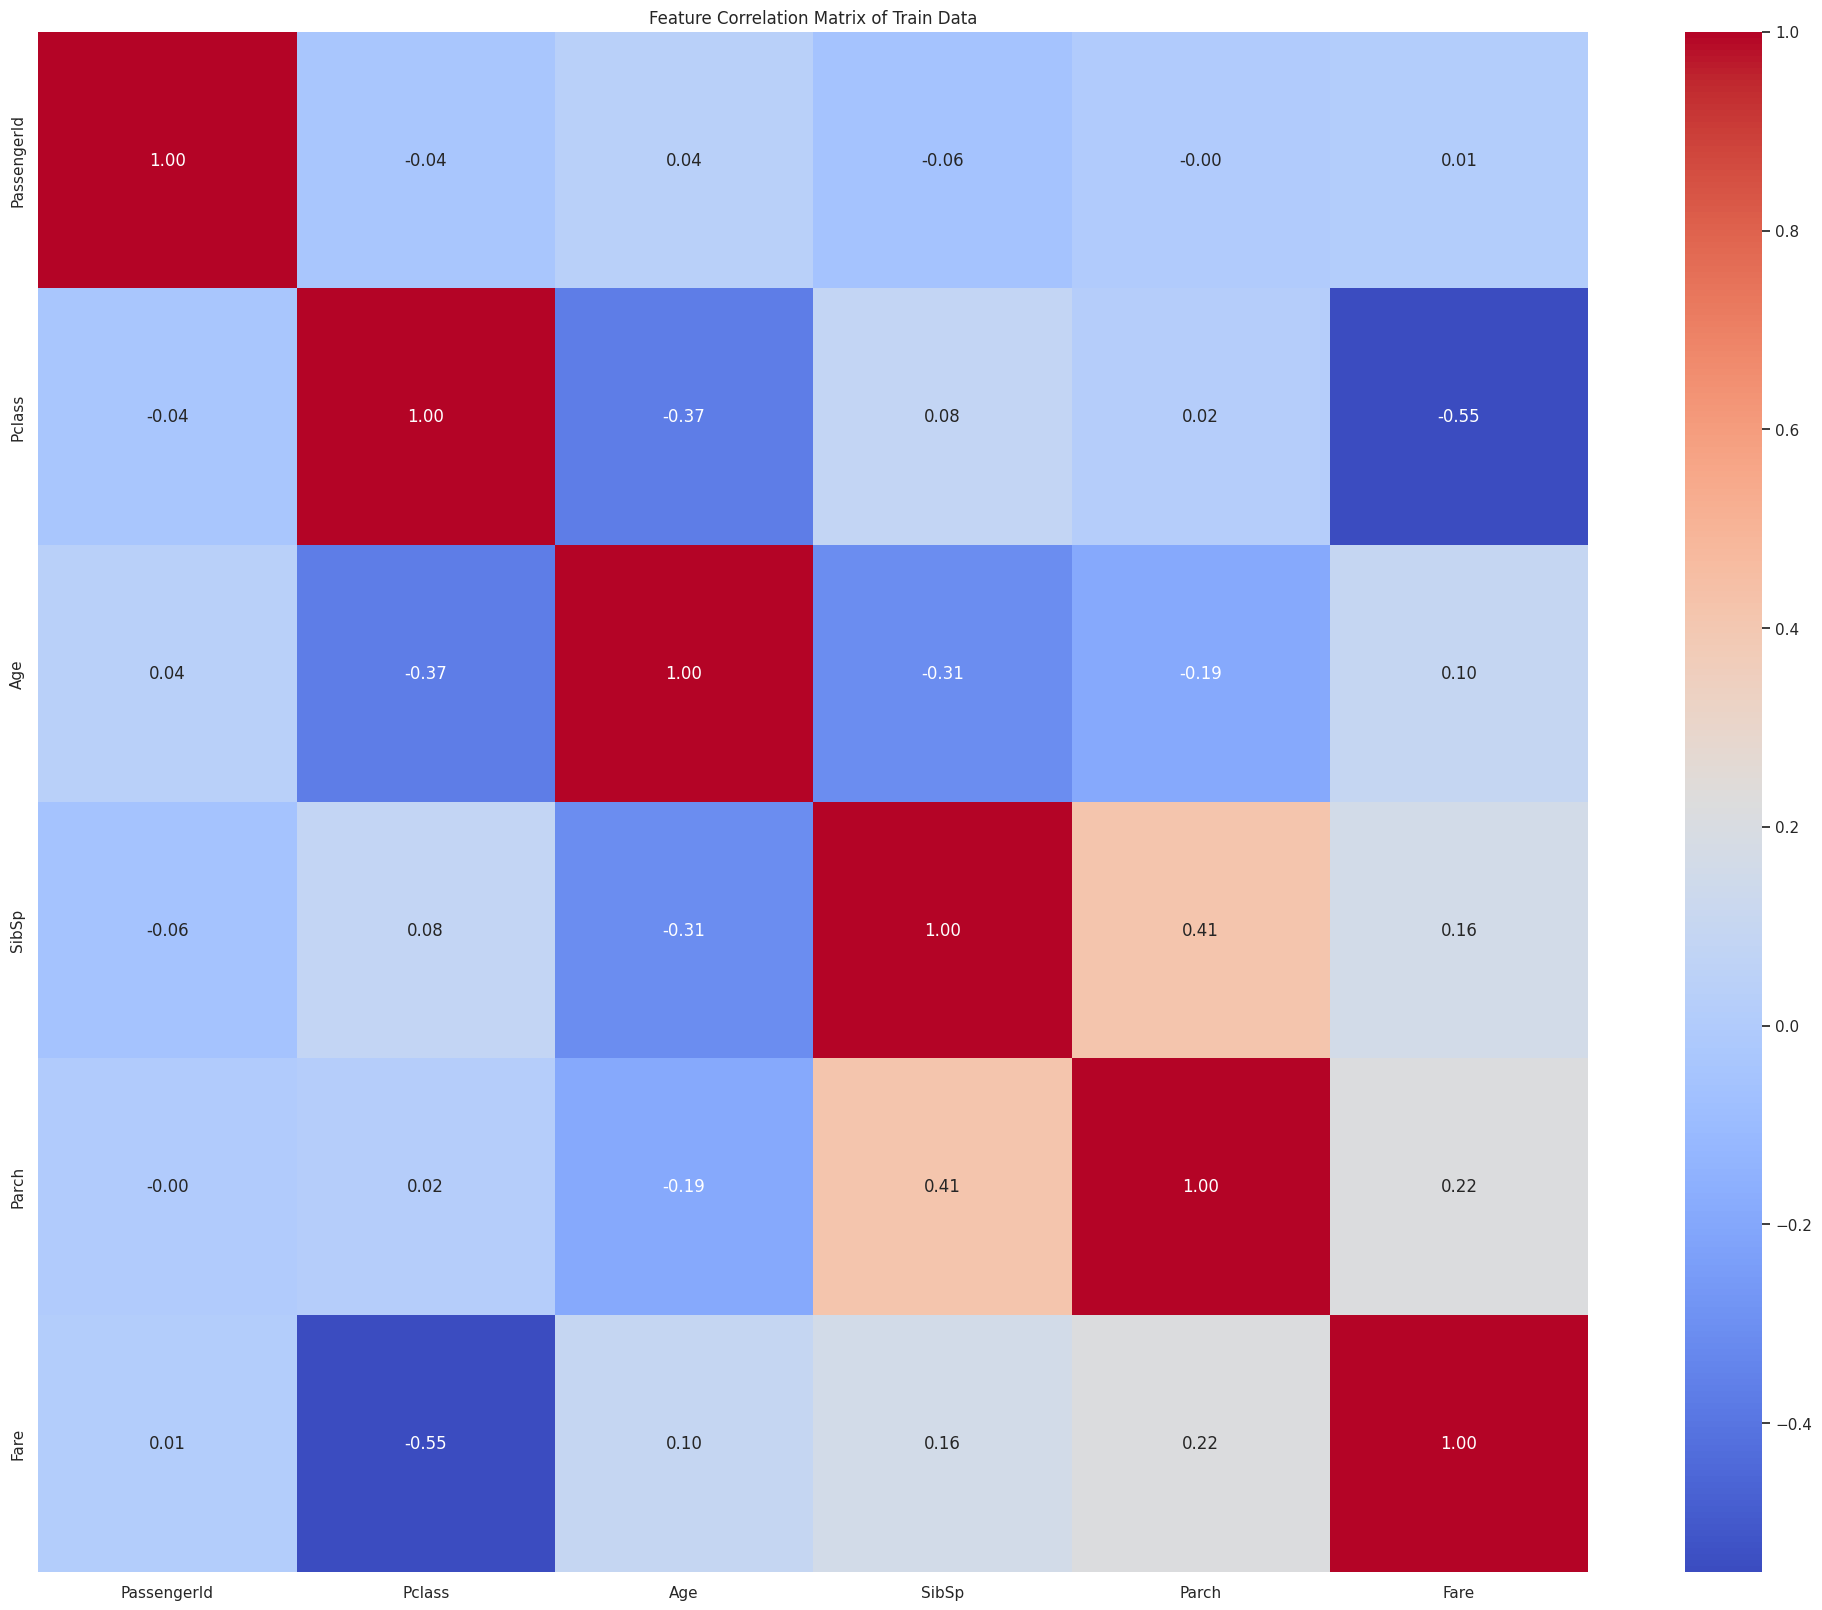

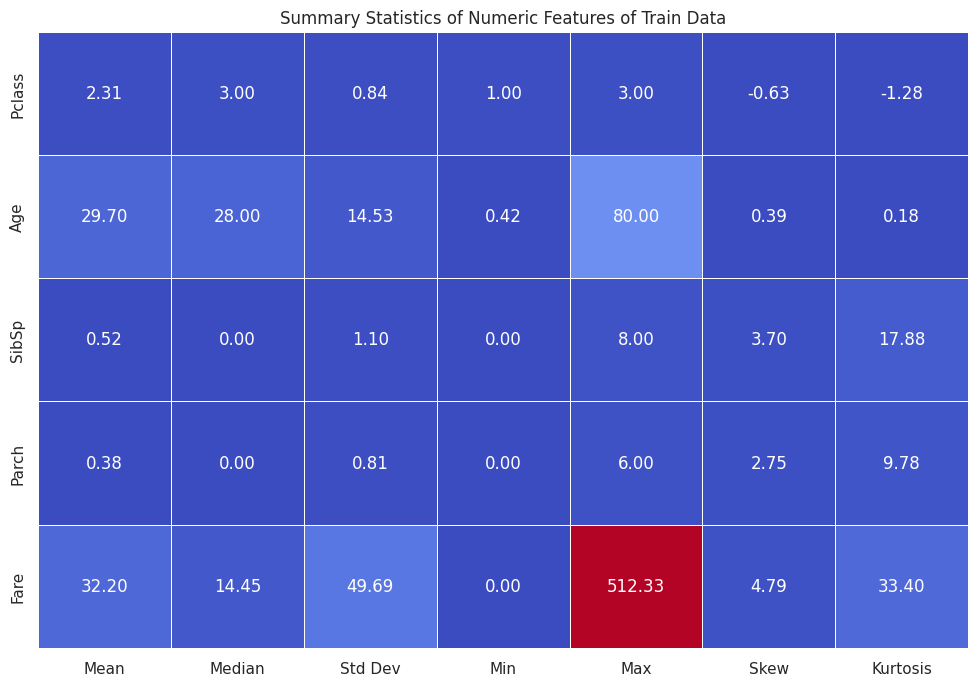

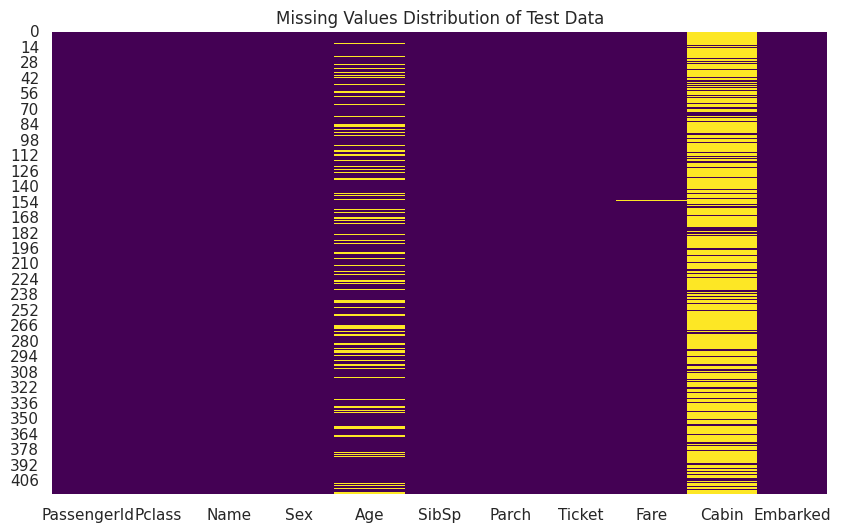

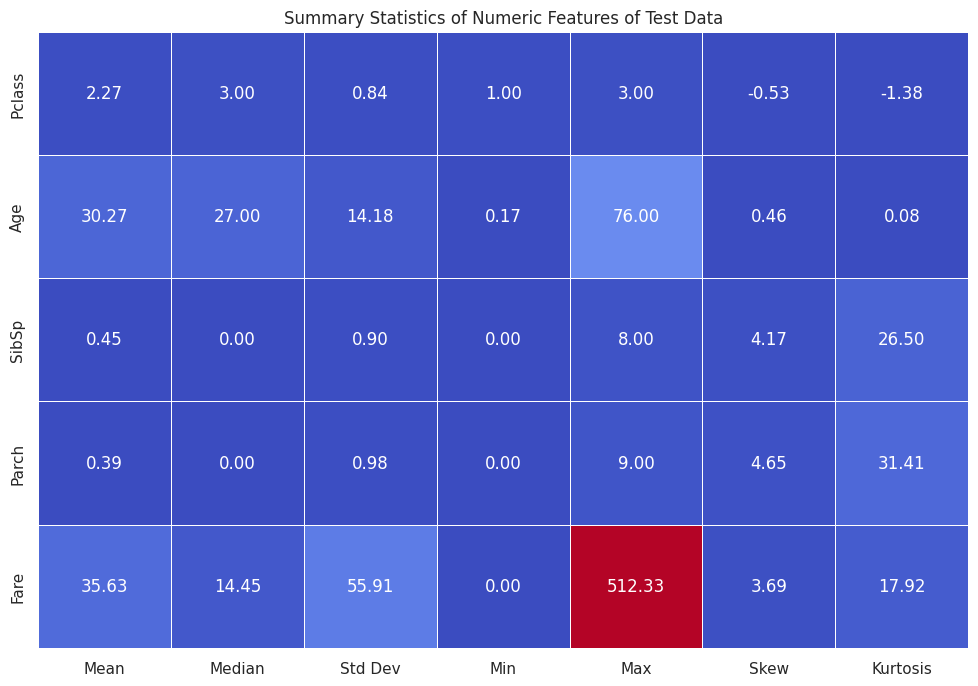

In [2]:
def visualize_data_analysis(df, df_name, q=[1, 2, 3, 4, 5], encoded_categorical_cols=['Survived', 'Sex', 'Embarked', 'Deck', 'Title', 'Title_Category', 'AgeGroup', 'Married']):
    df_temp = df.copy()
    
    if 1 in q:
        plt.figure(figsize=(10, 6))
        sns.heatmap(df_temp.isnull(), cbar=False, cmap='viridis')
        plt.title(f'Missing Values Distribution of {df_name}')
        plt.show()

    if 2 in q:
        numeric_df = df_temp.select_dtypes(include=[np.number])
        if not numeric_df.empty:
            numeric_df.hist(bins=20, figsize=(20, 15), edgecolor='black')
            plt.suptitle(f'Histograms of Numerical Features of {df_name}')
            plt.show()

    if 3 in q:
        numeric_df = df_temp.select_dtypes(include=[np.number])
        plt.figure(figsize=(25, 20))
        sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title(f'Feature Correlation Matrix of {df_name}')
        plt.show()
    
    if 4 in q:
        numeric_df = df_temp.select_dtypes(include=[np.number])
        if 'PassengerId' in numeric_df.columns:
            numeric_df = numeric_df.drop(columns=['PassengerId'])
        summary = numeric_df.describe().T
        summary['median'] = numeric_df.median()
        summary['skew'] = numeric_df.skew()
        summary['kurtosis'] = numeric_df.kurtosis()

        summary = summary[['mean', 'median', 'std', 'min', 'max', 'skew', 'kurtosis']]
        summary.columns = ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Skew', 'Kurtosis']

        plt.figure(figsize=(12, 8))
        sns.heatmap(summary, annot=True, cmap='coolwarm', cbar=False, fmt='.2f', linewidths=0.5)
        plt.title(f'Summary Statistics of Numeric Features of {df_name}')
        plt.show()
        
    if 5 in q:        
        # Plot categorical features with pie and bar charts
        for col in encoded_categorical_cols:
            if col in df_temp.columns and df_temp[col].nunique() <= 7:  # Ensure the column exists in df_temp and has <= 7 unique values
                fig, axes = plt.subplots(1, 2, figsize=(14, 6))

                # Use ax.pie directly to get wedges, texts, and autotexts
                wedges, texts, autotexts = axes[0].pie(
                    df_temp[col].value_counts(), autopct='%1.1f%%', colors=['#66b3ff', '#99ff99', '#ffcc99'], startangle=90
                )
                for text, autotext in zip(texts, autotexts):
                    text.set_rotation(45)  # Rotate the labels
                    autotext.set_rotation(45)
                axes[0].set_title(f'{col} Distribution (Pie)')
                axes[0].set_ylabel('')

                sns.countplot(data=df_temp, x=col, ax=axes[1])
                axes[1].set_title(f'{col} Distribution (Bar)')
                plt.tight_layout()
                plt.show()

# Visualize training data characteristics
visualize_data_analysis(train, "Train Data", q=[1, 2, 3, 4])
visualize_data_analysis(test, "Test Data", q=[1, 4])

## 2. Feature Engineering and Handling Missing Data
Feature engineering is crucial to improving the predictive power of the model. We create new features and handle missing data as follows:

1. Deck: Extracted from the Cabin column and grouped into categories.
1. Title: Extracted from the Name column and grouped into common categories.
1. FamilySize: Calculated as the sum of SibSp and Parch plus 1.
1. IsAlone: Indicates whether the passenger is traveling alone.
1. FarePerPerson: Calculated as Fare divided by FamilySize.
1. TicketPrefix and TicketNumber: Extracted from the Ticket column.
1. Title_Category: Maps titles to broader categories.
1. Sex_binary: Binary encoding of the Sex column.
1. GroupSize: Number of people traveling with the same ticket.
1. IsInGroup: Indicates whether the passenger is part of a group.
1. ParchSibSp: Product of Parch and SibSp.
1. FareBin: Binned version of FarePerPerson.
1. CabinCount: Number of cabins assigned to the passenger.

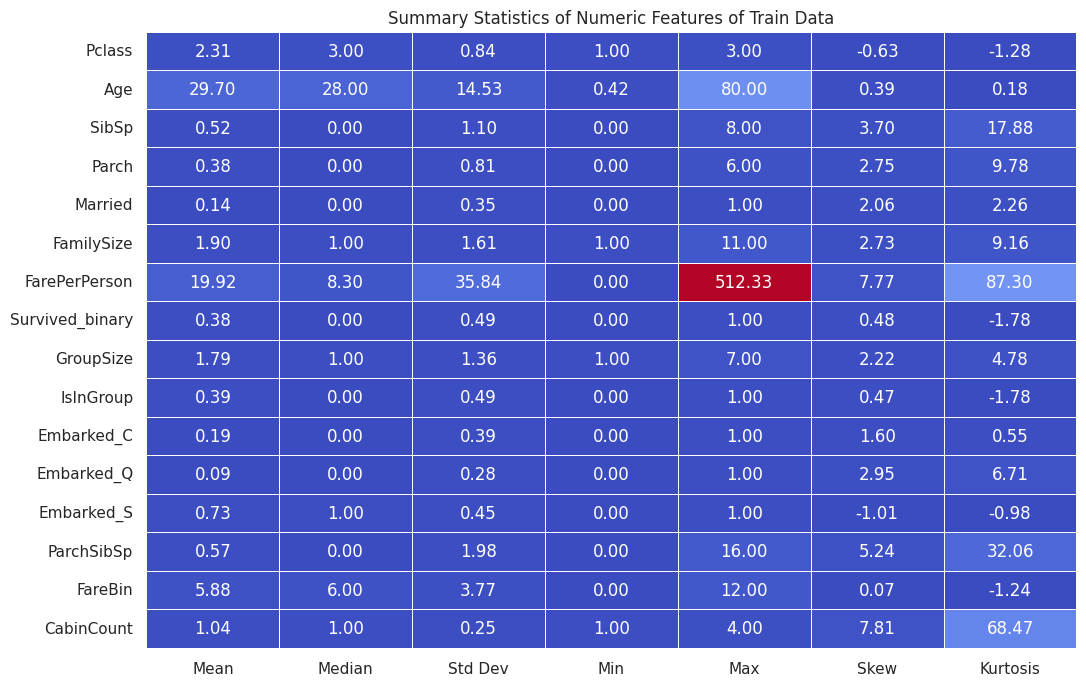

In [3]:
def extract_ticket_features(ticket):
    ticket = ticket.replace('.', '').replace('/', '').split()
    ticket_prefix = ticket[0] if not ticket[0].isdigit() else 'NoPrefix'
    ticket_number = ticket[-1] if ticket[-1].isdigit() else 'NoNumber'
    return ticket_prefix, ticket_number

def feature_engineering_encoding_missingData(df1, df2):
    combine = [df1.copy(), df2.copy()]
    for i in range(len(combine)):
        df_temp = combine[i]
        
        # When I googled Stone, Mrs. George Nelson (Martha Evelyn), I found that she embarked from S (Southampton) with her maid Amelie Icard, in this page Martha Evelyn Stone: Titanic Survivor.
        df_temp['Embarked'] = df_temp['Embarked'].fillna('S')

        # Fill missing 'Cabin' with 'Unknown'
        df_temp['Cabin'].fillna('Unknown', inplace=True)

        # Create deck feature extracted from the cabin number and replace it to be align with Pclass
        df_temp['Deck'] = df_temp['Cabin'].apply(lambda x: x[0])
        df_temp['Deck'] = df_temp['Deck'].replace(['A', 'B', 'C'], 'ABC')
        df_temp['Deck'] = df_temp['Deck'].replace(['D', 'E'], 'DE')
        df_temp['Deck'] = df_temp['Deck'].replace(['F', 'G'], 'FG')
        

        # Create new features
        df_temp['Title'] = df_temp['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
        df_temp['Title'] = df_temp['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Master', 'Jonkheer', 'Dona'], 'Rare')
        df_temp['Title'] = df_temp['Title'].replace(['Mlle', 'Ms'], 'Miss')
        df_temp['Title'] = df_temp['Title'].replace('Mme', 'Mrs')
        df_temp['Married'] = df_temp['Title'].apply(lambda x: 1 if x == 'Mrs' else 0)
        df_temp['Title'] = df_temp['Title'].apply(lambda x: 'Rare' if x not in ['Mr', 'Mrs', 'Miss'] else x)

        df_temp['FamilySize'] = df_temp['SibSp'] + df_temp['Parch'] + 1
        df_temp['IsAlone'] = df_temp['FamilySize'].apply(lambda x: 1 if x == 1 else 0)
        
        # Median of a Fare satisying condition([3][0][0] -- 3=Pclass,0=Parch,SibSp) based on the only missing sample
        # Filling the missing value in Fare with the median Fare of 3rd class alone passenger
        med_fare = df_temp.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].median()[3][0][0]
        df_temp['Fare'] = df_temp['Fare'].fillna(med_fare)
        
        df_temp['FarePerPerson'] = df_temp['Fare'] / df_temp['FamilySize']
        df_temp = df_temp.drop(columns=['Fare'])

        df_temp[['TicketPrefix', 'TicketNumber']] = df_temp['Ticket'].apply(lambda x: pd.Series(extract_ticket_features(x)))

        title_mapping = {'Mr': 'Common', 'Mrs': 'Common', 'Miss': 'Common', 'Master': 'Common', 'Rare': 'Royalty'}
        df_temp['Title_Category'] = df_temp['Title'].map(title_mapping)

        if 'Survived' in df_temp.columns:
            df_temp['Survived_binary'] = df_temp['Survived'].map({'T': 1, 'F': 0})

        df_temp['Sex_binary'] = df_temp['Sex'].map({'male': 0, 'female': 1})
        df_temp['GroupSize'] = df_temp.groupby('Ticket')['Ticket'].transform('count')
        df_temp['IsInGroup'] = df_temp['GroupSize'].apply(lambda x: 1 if x > 1 else 0)

        # Apply one-hot encoding
        one_hot_encoded = pd.get_dummies(df_temp[['Title','Married']], drop_first=True)
        one_hot_encoded = pd.get_dummies(df_temp[['Embarked']], drop_first=False) ################,'Deck'

        one_hot_encoded = one_hot_encoded.astype(int)
        df_temp = df_temp.drop(columns=['Sex_binary', 'IsAlone' ])
        df_temp = pd.concat([df_temp, one_hot_encoded], axis=1)

        df_temp['ParchSibSp'] = df_temp['Parch'] * df_temp['SibSp']
        
        df_temp['FareBin'] = pd.qcut(df_temp['FarePerPerson'], 13, labels=False)
        
        df_temp['CabinCount'] = df_temp['Cabin'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
        
        # Mapping Family Size
        family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 9: 'Large', 10: 'Large', 11: 'Large'}
        df_temp['Family_Size_Grouped'] = df_temp['FamilySize'].map(family_map)
        
        combine[i] = df_temp

    return combine[0], combine[1]

train_encoded, test_encoded = feature_engineering_encoding_missingData(train, test)

visualize_data_analysis(train_encoded, "Train Data",q=[4])


## 3. Explore Features Distributions Segmented with Survived

To understand how different features affect the survival rate, we explore the distributions of categorical features segmented by the `Survived` column. This helps us visualize the impact of each feature on survival.


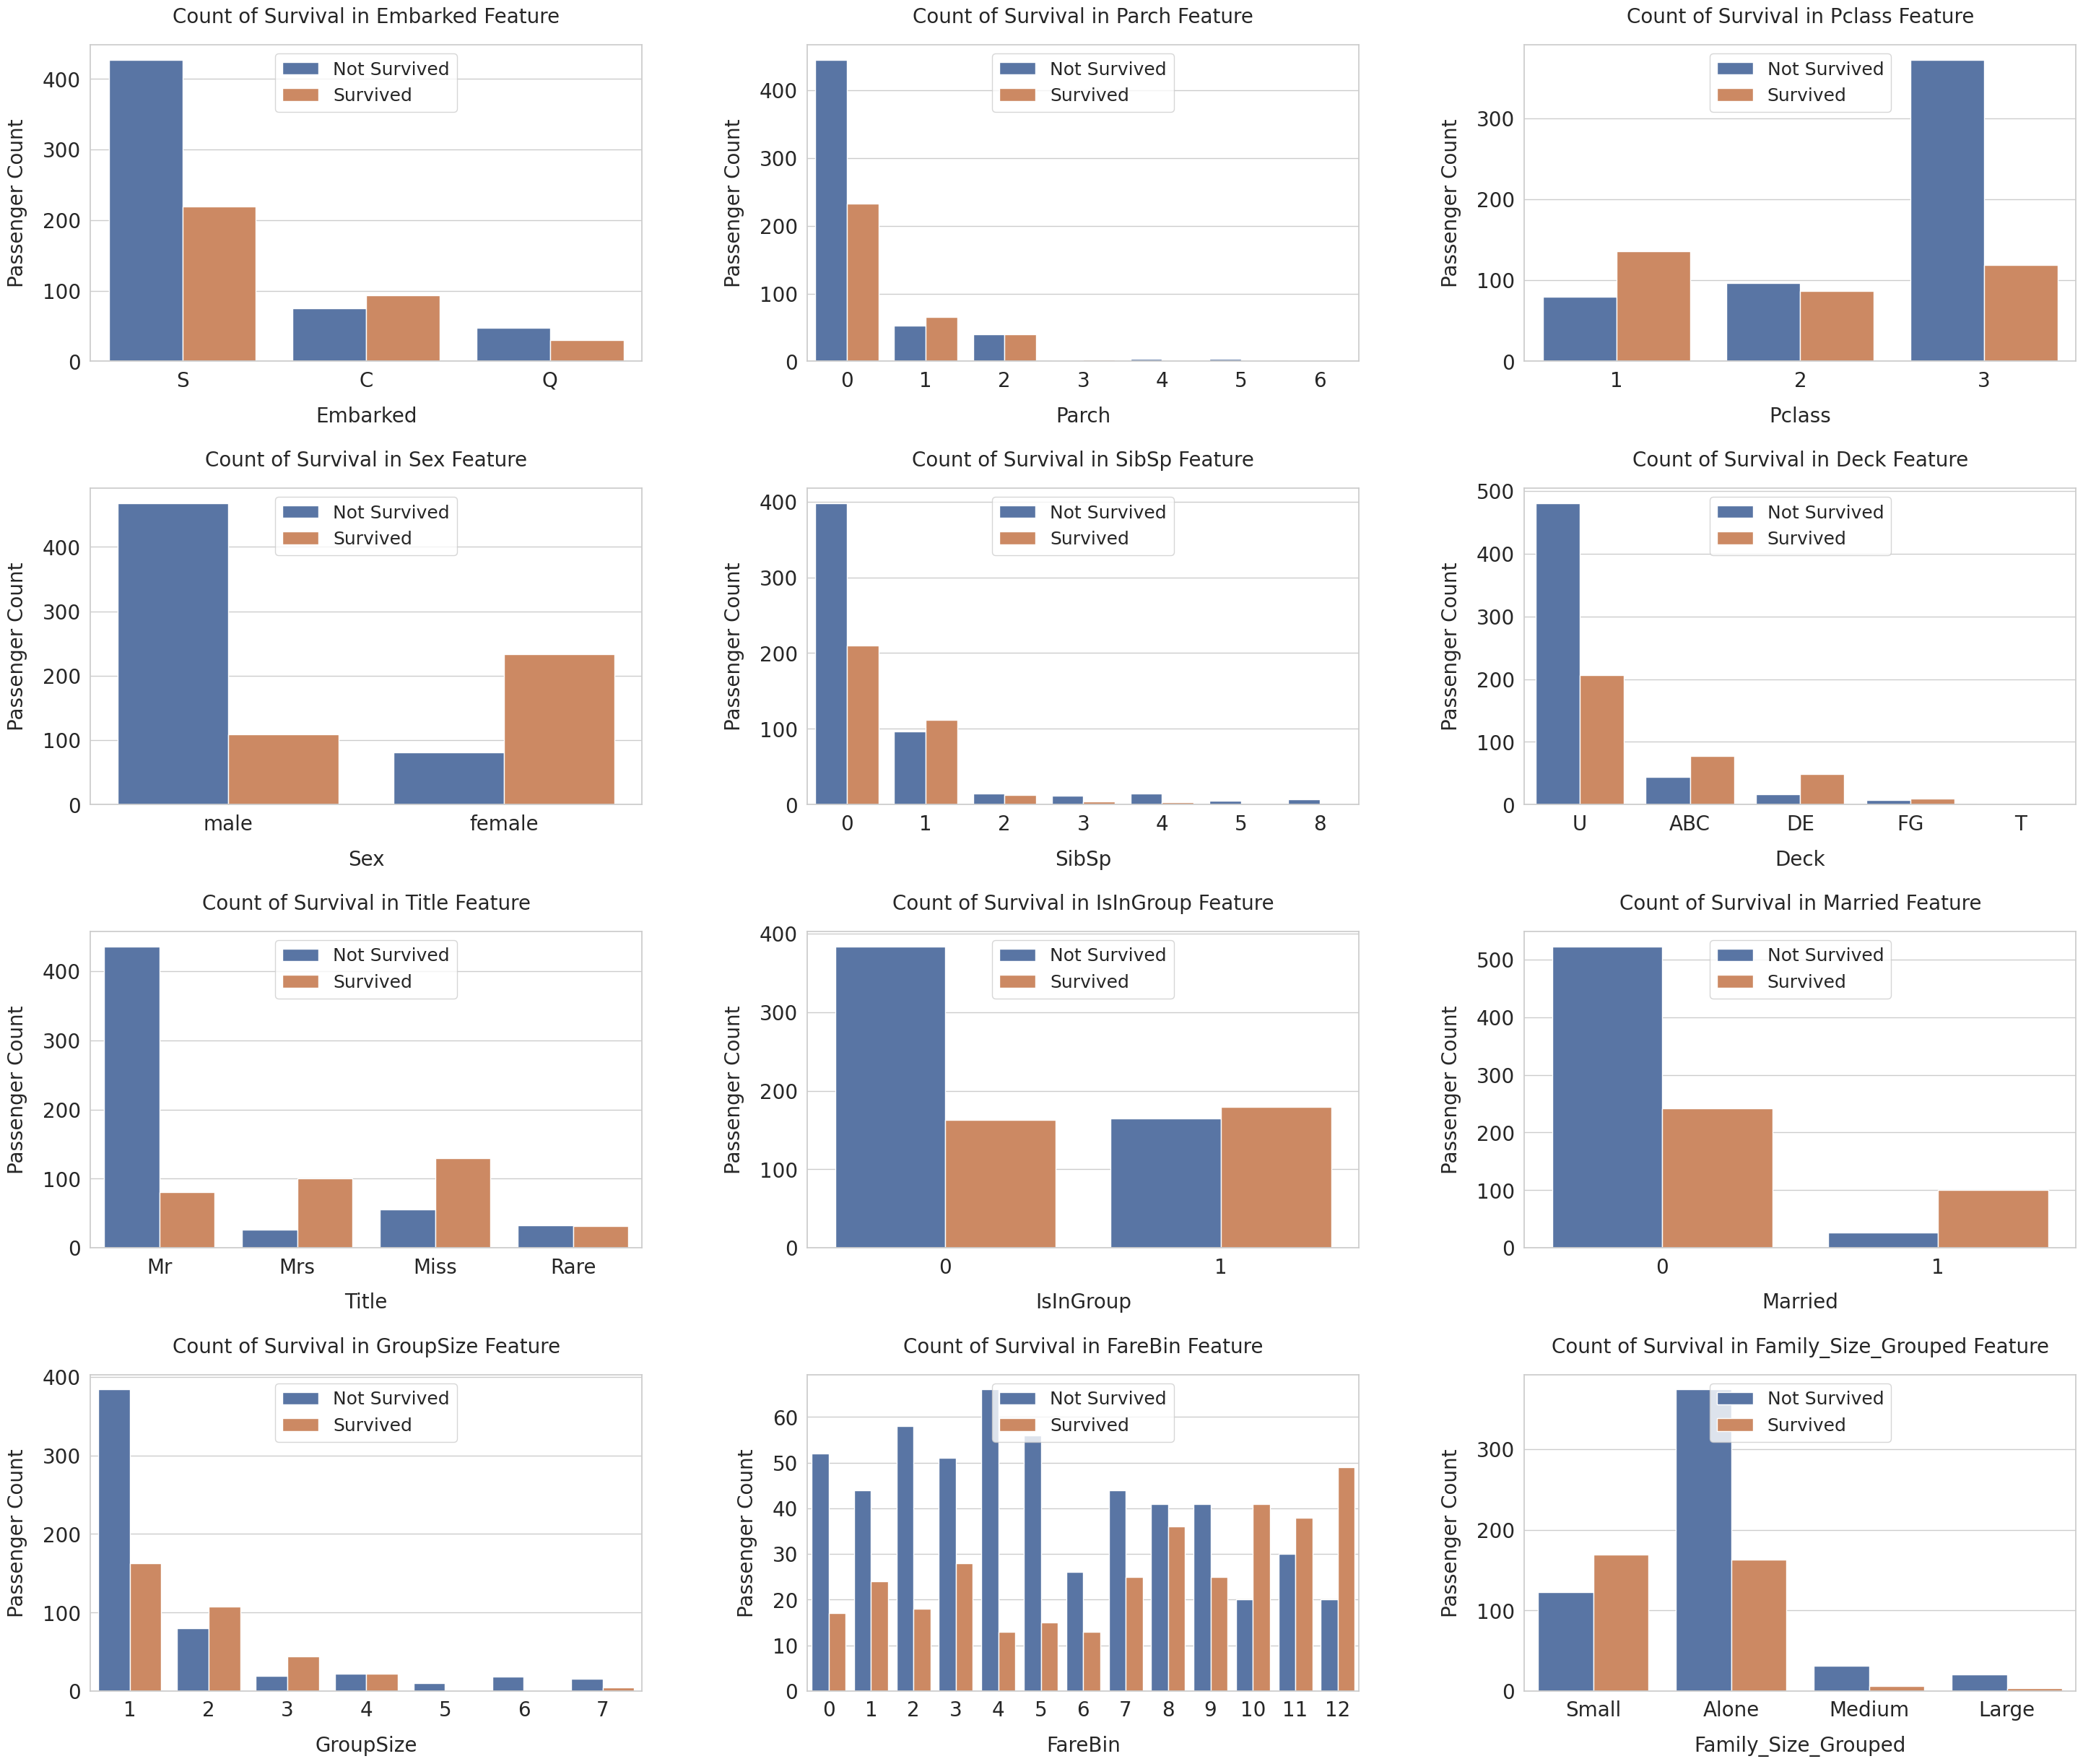

In [4]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck','Title','IsInGroup','Married','GroupSize','FareBin','Family_Size_Grouped']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(4, 3, i)
    sns.countplot(x=feature, hue='Survived', data=train_encoded)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust the values as needed

plt.show()


## 4. Label Encoding for Categorical Features
We need to convert categorical features into numerical values for the machine learning models to process them. We use LabelEncoder to transform the categorical columns.

In [5]:
le = LabelEncoder()
categorical_cols = ['Embarked', 'Deck', 'Title', 'TicketPrefix', 'Title_Category','Family_Size_Grouped','TicketNumber']
combine = [train_encoded, test_encoded]
for df_temp in combine:
    for col in categorical_cols:
        df_temp[col] = le.fit_transform(df_temp[col].astype(str))


## 5. Forecasting Missing Ages
Missing values in the Age column can be significant for our model. We use a combination of mutual information, decision trees, and k-nearest neighbors to predict and fill in the missing ages.

### 5.1 Separating Rows with Missing and Non-missing Ages

In [6]:
def separate_missing_ages(df):
    df_missing_age = df[df['Age'].isnull()]
    df_non_missing_age = df[df['Age'].notnull()]
    return df_missing_age, df_non_missing_age


### 5.2 Selecting Best Features Using Mutual Information


In [7]:
def select_features(X, y, num_features, plot=True):
    # Ensure all features are numeric
    X_numeric = X.select_dtypes(include=[np.number])
    mi = mutual_info_regression(X_numeric, y)
    mi_series = pd.Series(mi, index=X_numeric.columns)
    selected_features = mi_series.sort_values(ascending=False).head(num_features).index.tolist()

    if plot:
        plt.figure(figsize=(10, 6))
        mi_series.sort_values(ascending=False).plot(kind='bar')
        plt.title('Mutual Information of Features with Age')
        plt.xlabel('Features')
        plt.ylabel('Mutual Information Score')
        plt.show()

    return sorted(selected_features)


### 5.3 Training Age Predictors


In [8]:
def train_age_predictors(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    param_grid_dt = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    param_grid_knn = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }

    models = {
        'Decision Tree': (DecisionTreeRegressor(), param_grid_dt),
        'K-Nearest Neighbors': (KNeighborsRegressor(), param_grid_knn)
    }

    best_models = {}
    for name in models:
        model, param_grid = models[name]
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_scaled, y)
        best_models[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Best neg MSE score for {name}: {grid_search.best_score_}")

    voting_regressor = VotingRegressor(estimators=[
        ('dt', best_models['Decision Tree']),
        ('knn', best_models['K-Nearest Neighbors'])
    ])
    voting_regressor.fit(X_scaled, y)

    return best_models, voting_regressor, scaler


### 5.4 Predicting Missing Ages


In [9]:
def predict_missing_ages(voting_regressor, scaler, df_missing_age, features):
    X_missing = df_missing_age[features].sort_index(axis=1)
    X_missing_scaled = scaler.transform(X_missing)
    df_missing_age['Age'] = voting_regressor.predict(X_missing_scaled)
    return df_missing_age


### 5.5 Handling Skewness in Data


In [10]:
def get_skewed_features(df, threshold=0.5, high_skew_threshold=1.0):
    df_copy = df.copy()
    numerical_features = df_copy.select_dtypes(include=[np.number]).columns.tolist()
    excluded_features = ['Sex_binary', 'IsChild', 'Married', 'Title_Category', 'PassengerId']
    numerical_features = [feature for feature in numerical_features if feature not in excluded_features]
    
    skew_df = df_copy[numerical_features].apply(lambda x: x.skew())
    kurtosis_df = df_copy[numerical_features].apply(lambda x: x.kurtosis())
    skew_df = skew_df.sort_values(ascending=False)
    skew_df = skew_df.reset_index()
    skew_df.columns = ['Feature', 'SkewFactor']
    kurtosis_df = kurtosis_df.reset_index()
    kurtosis_df.columns = ['Feature', 'Kurtosis']
    skew_kurtosis_df = pd.merge(skew_df, kurtosis_df, on='Feature')
    highly_skewed_features = list(skew_kurtosis_df[skew_kurtosis_df['SkewFactor'] > high_skew_threshold]['Feature'])
    moderately_skewed_features = list(skew_kurtosis_df[(skew_kurtosis_df['SkewFactor'] > threshold) & (skew_kurtosis_df['SkewFactor'] <= high_skew_threshold)]['Feature'])
    non_skewed_features = list(set(numerical_features) - set(moderately_skewed_features) - set(highly_skewed_features))
    return highly_skewed_features, moderately_skewed_features, non_skewed_features, skew_kurtosis_df

def transform_highly_skewed_features(df, highly_skewed_features):
    df_copy = df.copy()
    for col in highly_skewed_features:
        try:
            transformed_data, _ = stats.boxcox(df_copy[col] + 1)  # Ensure positive values
            df_copy[col] = transformed_data
        except Exception:
            df_copy[col] = np.log1p(df_copy[col])
    return df_copy

def transform_moderately_skewed_features(df, moderately_skewed_features):
    df_copy = df.copy()
    for col in moderately_skewed_features:
        df_copy[col] = np.log1p(df_copy[col])
    return df_copy

def transform_non_skewed_features(df, non_skewed_features):
    df_copy = df.copy()
    scaler = StandardScaler()
    df_copy[non_skewed_features] = scaler.fit_transform(df_copy[non_skewed_features])
    return df_copy

def skew_groups(df_train, df_test):
    combine = [df_train.copy(), df_test.copy()]
    for i in range(len(combine)):
        df_temp = combine[i]
        highly_skewed_features, moderately_skewed_features, non_skewed_features, skew_kurtosis_df = get_skewed_features(df_temp, threshold=0.5, high_skew_threshold=1.0)
        df_temp = transform_highly_skewed_features(df_temp, highly_skewed_features)
        df_temp = transform_moderately_skewed_features(df_temp, moderately_skewed_features)
        df_temp = transform_non_skewed_features(df_temp, non_skewed_features)
        combine[i] = df_temp
    return combine[0], combine[1]

def visualize_distributions(df, highly_skewed_features, moderately_skewed_features, skew_kurtosis_df, threshold=0.1):
    df_copy = df.copy()
    significant_features = highly_skewed_features + moderately_skewed_features
    
    num_features = len(significant_features)
    if num_features == 0:
        print("No significant changes in skewness detected.")
        return
    
    fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(14, 6 * num_features))
    
    for i, col in enumerate(significant_features):
        original_skewness = df_copy[col].skew()
        original_kurtosis = skew_kurtosis_df[skew_kurtosis_df['Feature'] == col]['Kurtosis'].values[0]
        sns.histplot(df_copy[col].dropna(), kde=True, ax=axes[i, 0], color='blue', bins=30)
        axes[i, 0].set_title(f'Before: {col} (Skewness: {original_skewness:.2f}, Kurtosis: {original_kurtosis:.2f})', fontsize=14)
        axes[i, 0].set_xlabel('')
        axes[i, 0].set_ylabel('')
    
    # Apply the transformations
    df_copy = transform_highly_skewed_features(df_copy, highly_skewed_features)
    df_copy = transform_moderately_skewed_features(df_copy, moderately_skewed_features)
    df_copy = transform_non_skewed_features(df_copy, list(set(df_copy.select_dtypes(include=[np.number]).columns) - set(significant_features)))
    
    for i, col in enumerate(highly_skewed_features):
        transformed_skewness = df_copy[col].skew()
        transformed_kurtosis = df_copy[col].kurtosis()
        sns.histplot(df_copy[col].dropna(), kde=True, ax=axes[i, 1], color='green', bins=30)
        axes[i, 1].set_title(f'After (Box-Cox): {col} (Skewness: {transformed_skewness:.2f}, Kurtosis: {transformed_kurtosis:.2f})', fontsize=14)
        axes[i, 1].set_xlabel('')
        axes[i, 1].set_ylabel('')
    
    for i, col in enumerate(moderately_skewed_features, len(highly_skewed_features)):
        transformed_skewness = df_copy[col].skew()
        transformed_kurtosis = df_copy[col].kurtosis()
        sns.histplot(df_copy[col].dropna(), kde=True, ax=axes[i, 1], color='green', bins=30)
        axes[i, 1].set_title(f'After (Log): {col} (Skewness: {transformed_skewness:.2f}, Kurtosis: {transformed_kurtosis:.2f})', fontsize=14)
        axes[i, 1].set_xlabel('')
        axes[i, 1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    return df_copy


### 5.6 Process and Transform the Data


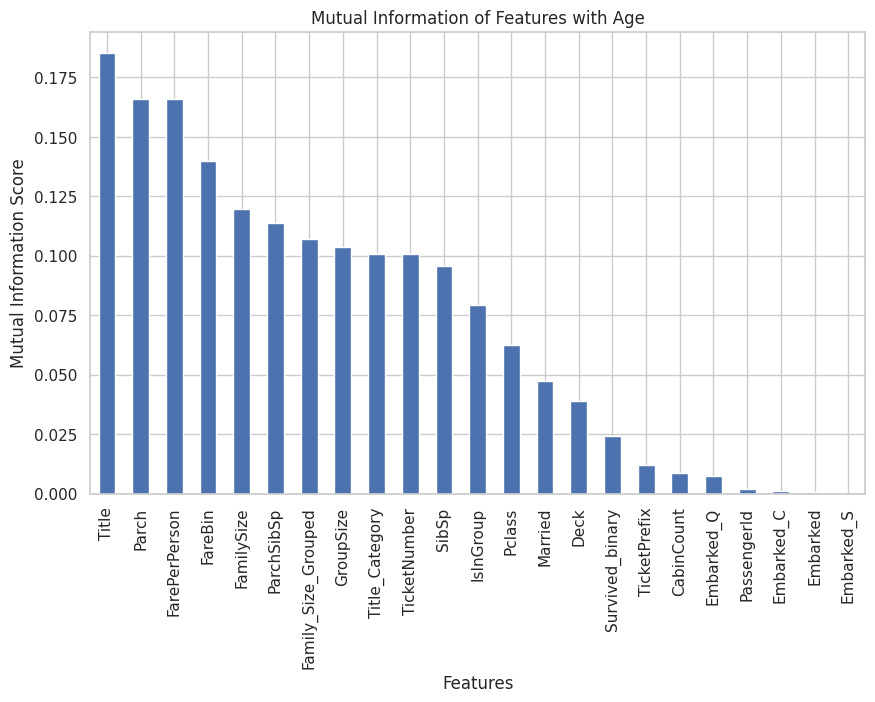

Best parameters for Decision Tree: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10}
Best neg MSE score for Decision Tree: -148.99023229333017
Best parameters for K-Nearest Neighbors: {'algorithm': 'brute', 'n_neighbors': 11, 'weights': 'uniform'}
Best neg MSE score for K-Nearest Neighbors: -136.396619828443


In [11]:
# Separate rows with missing and non-missing ages for training data
df_missing_age_train, df_non_missing_age_train = train_encoded[train_encoded['Age'].isnull()], train_encoded[train_encoded['Age'].notnull()]
df_missing_age_test, df_non_missing_age_test = test_encoded[test_encoded['Age'].isnull()], test_encoded[test_encoded['Age'].notnull()]

# Prepare training data
X_train = df_non_missing_age_train.drop(columns=['Age'])
y_train = df_non_missing_age_train['Age']

# Select best features using MI
selected_features = select_features(X_train, y_train, num_features=7)
X_train_selected = X_train[selected_features]

# Train the models
_, voting_regressor, scaler = train_age_predictors(X_train_selected, y_train)

# Ensure the selected features are present in both train and test datasets
common_features = list(set(selected_features) & set(df_missing_age_test.columns))

# Scale the data
X_train_selected_scaled = scaler.fit_transform(X_train_selected)

# Train the voting regressor on scaled data
voting_regressor.fit(X_train_selected_scaled, y_train)

# Process skewness for missing age data
df_missing_age_train, df_missing_age_test = skew_groups(df_missing_age_train, df_missing_age_test)

# Predict missing ages for training and test data
df_missing_age_train = predict_missing_ages(voting_regressor, scaler, df_missing_age_train, common_features)
df_missing_age_test = predict_missing_ages(voting_regressor, scaler, df_missing_age_test, common_features)

# Combine the non-missing and newly predicted ages for training and test data
train_encoded['Age'] = pd.concat([df_non_missing_age_train['Age'], df_missing_age_train['Age']])
test_encoded['Age'] = pd.concat([df_non_missing_age_test['Age'], df_missing_age_test['Age']])


## 6. Creating Age-Related Features

We categorize ages into different groups (e.g., Baby, Child, Teenager, etc.) and create a new feature representing these groups. This helps the model understand the age distribution better.

### New Age Features:
1. AgeGroupNum: Binned age into numerical categories.
1. AgeGroup: Binned age into categorical groups such as Baby, Child, etc.
1. age_sex_string: Combined age group and sex into a single string.
1. age_sex_encoded: Encoded age_sex_string into numerical values.
1. IsChild: A binary feature indicating whether the passenger is a child (age < 18).

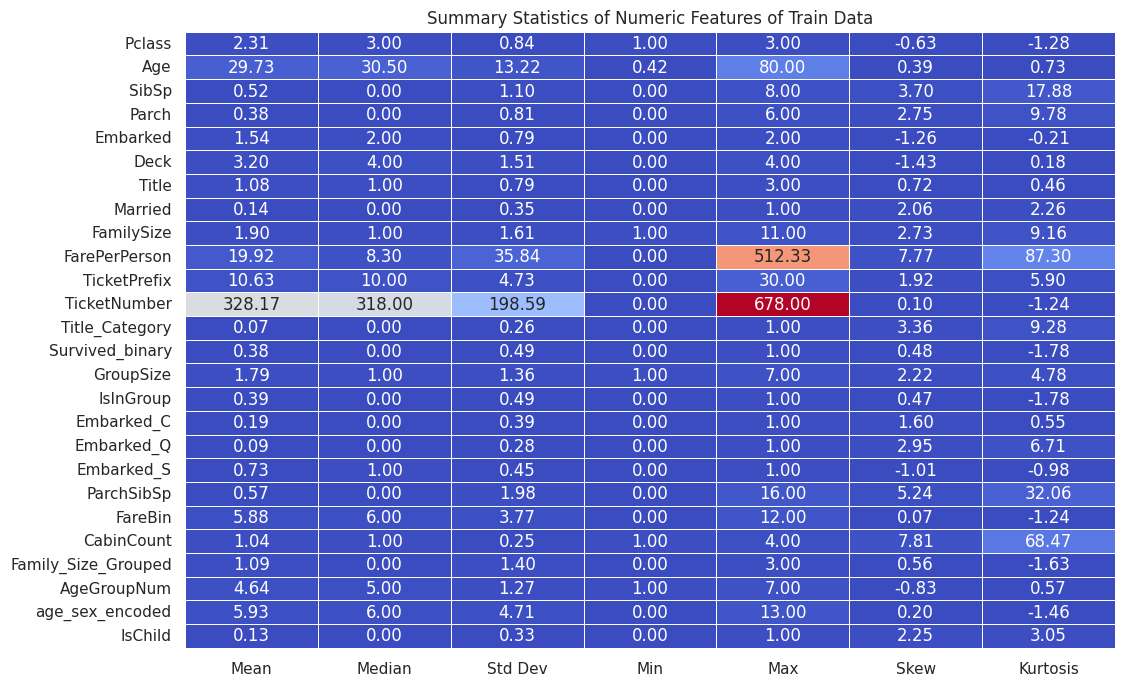

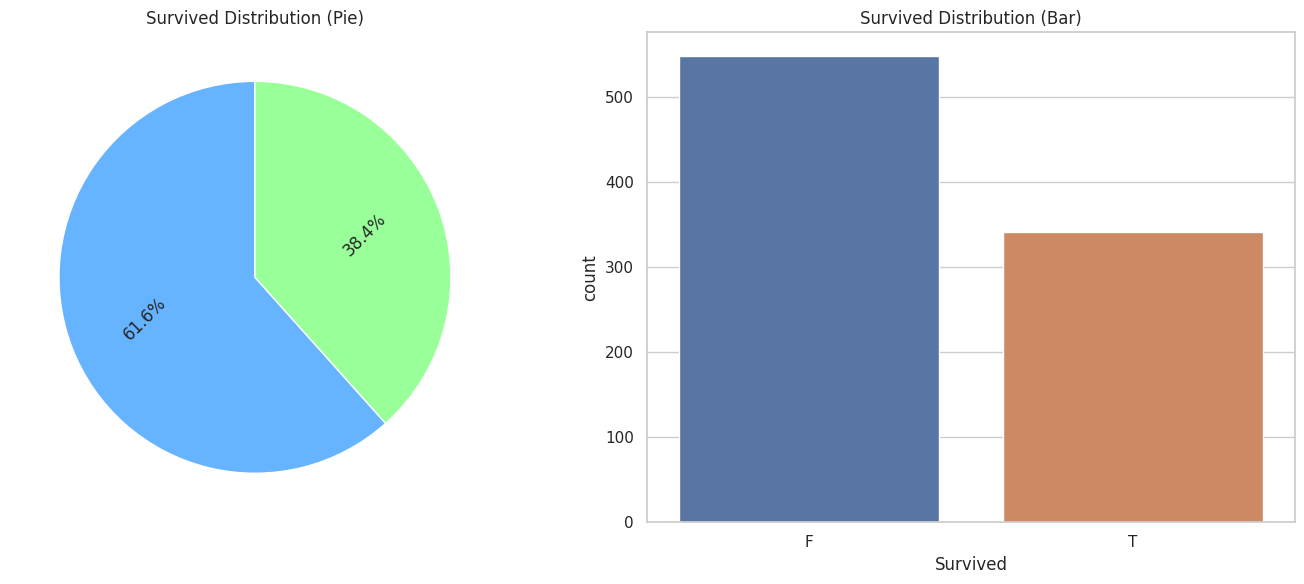

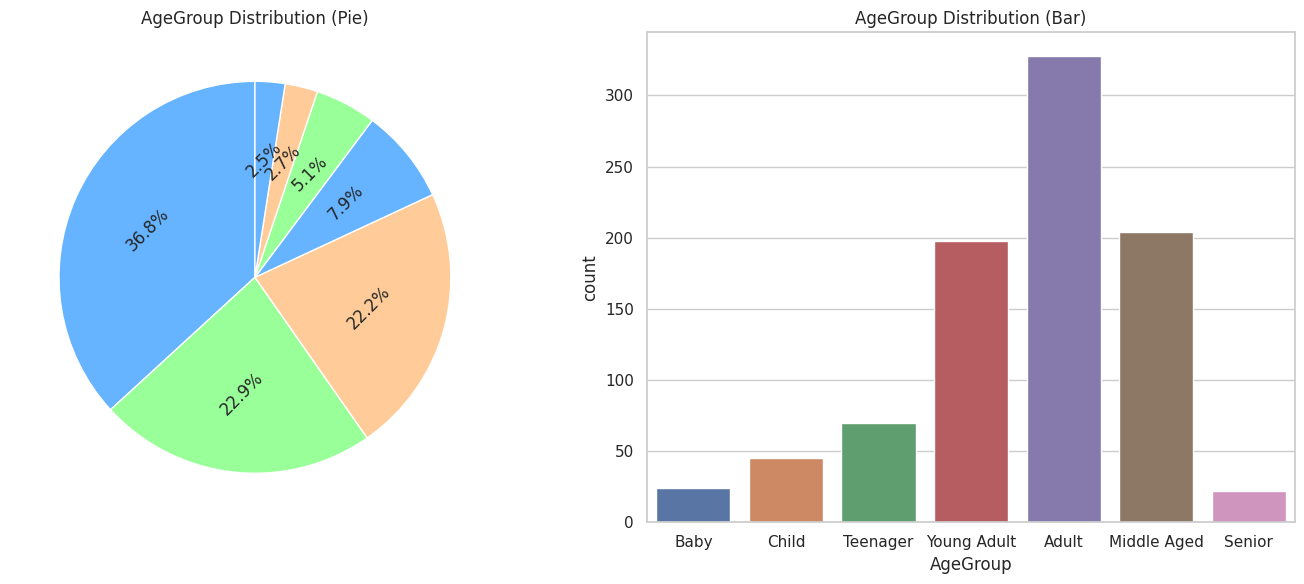

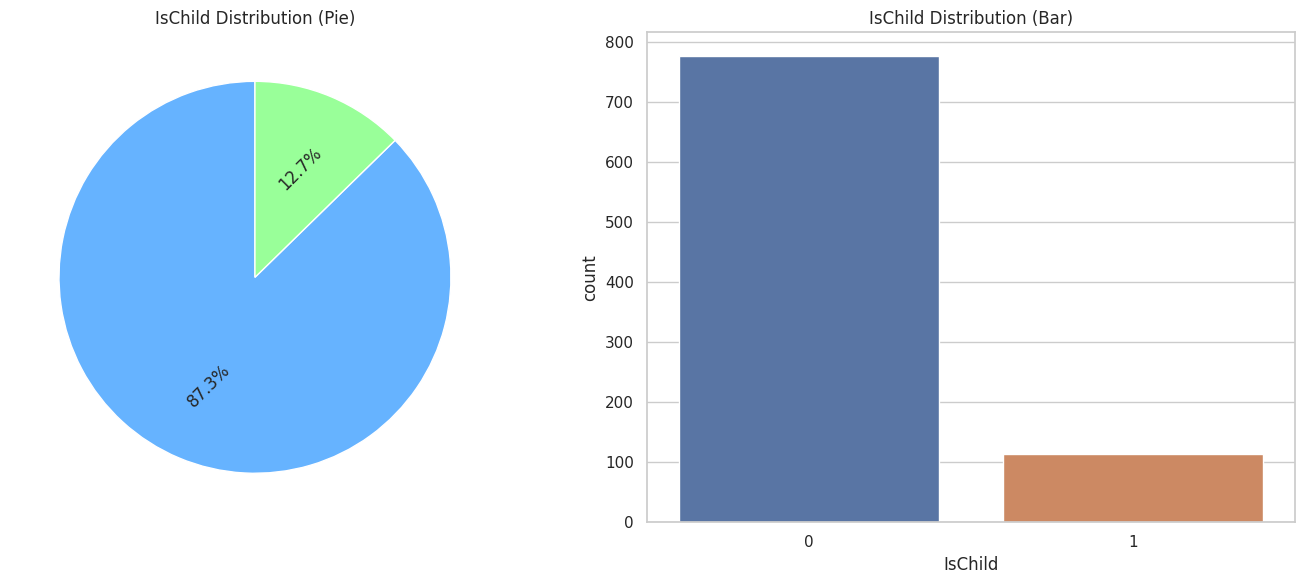

In [12]:
def age_related_features(df):
    age_bins = [0, 2, 12, 18, 25, 35, 60, np.inf]
    age_labels = [1, 2, 3, 4, 5, 6, 7]
    df['AgeGroupNum'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels).astype(int)

    age_labels = ['Baby', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Middle Aged', 'Senior']
    df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)
    df['age_sex_string'] = (df['AgeGroup'].str.lower() + ' - ' + df['Sex'].str.lower())

    label_encoder = LabelEncoder()
    df['age_sex_encoded'] = label_encoder.fit_transform(df['age_sex_string'])
    df['IsChild'] = df['Age'].apply(lambda x: 1 if x < 18 else 0)

age_related_features(train_encoded)
age_related_features(test_encoded)

visualize_data_analysis(train_encoded, "Train Data", [4, 5], encoded_categorical_cols=['Survived','AgeGroup','IsChild','age_sex_string'])


## 7. Final Standardization
Standardize and transform the final features for modeling.

### Transformations:
1. Age: Standard scaling to normalize the distribution.
1. FarePerPerson: Log transformation to handle high skewness.
1. TicketNumber: Quantile transformation to handle kurtosis.

* drop sex binary since sex_age is better scored by MI

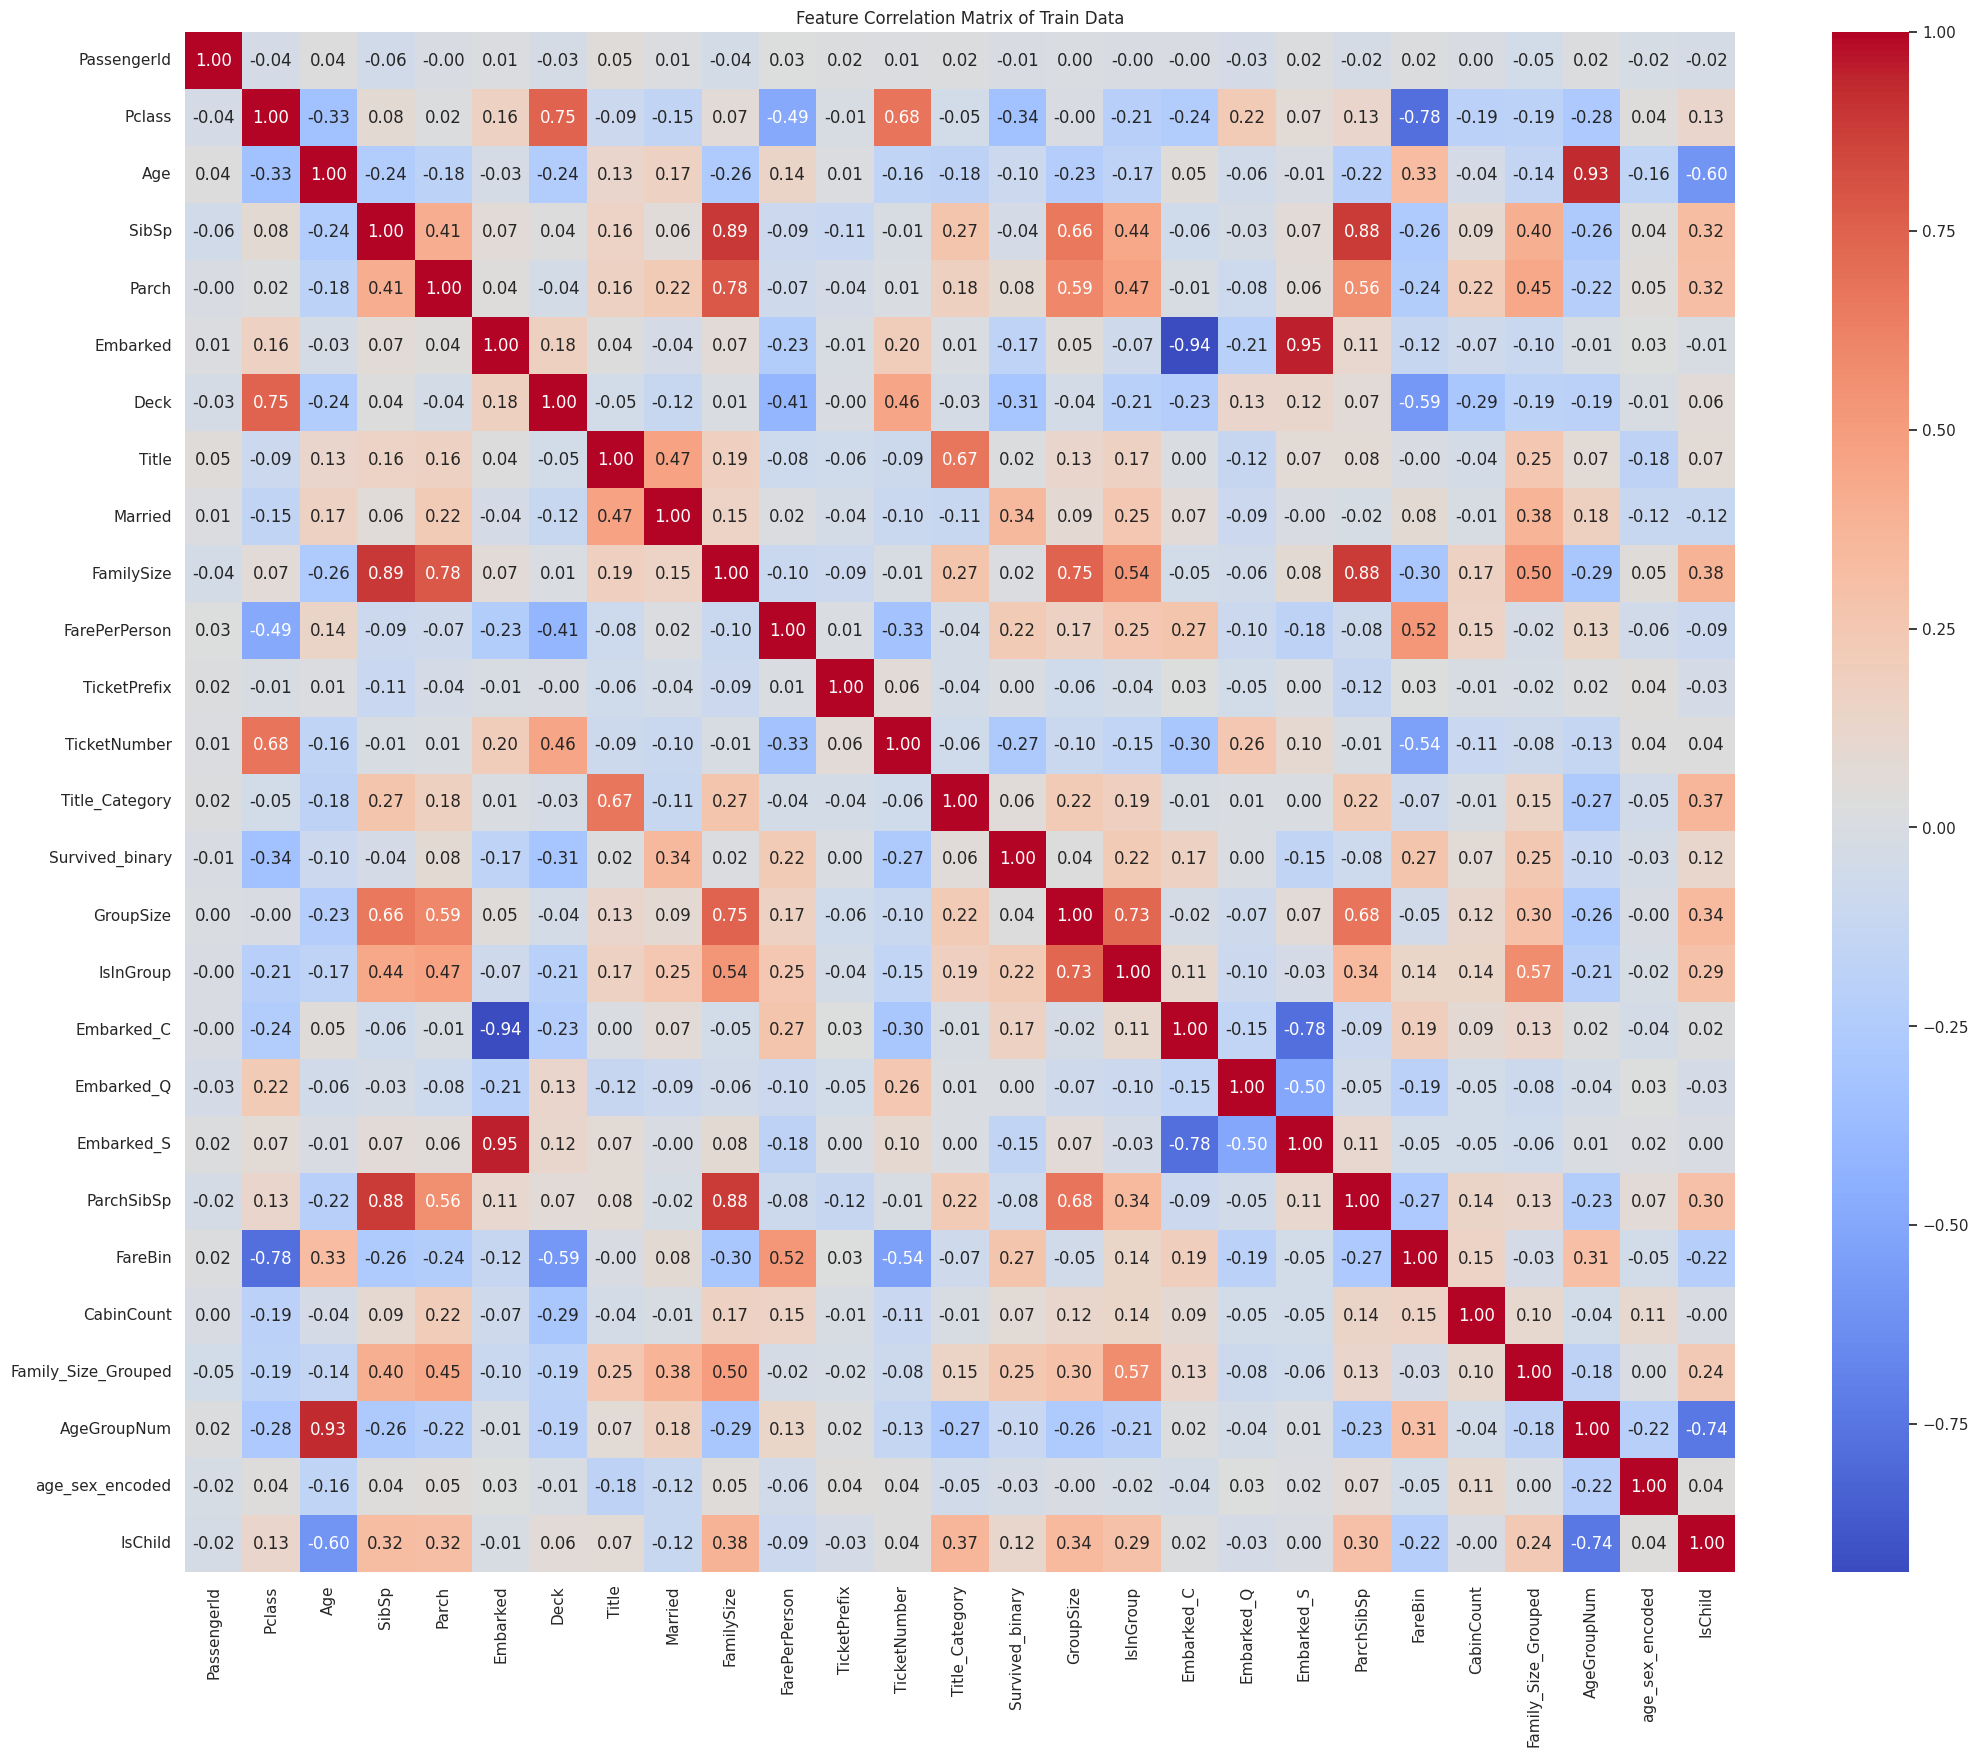

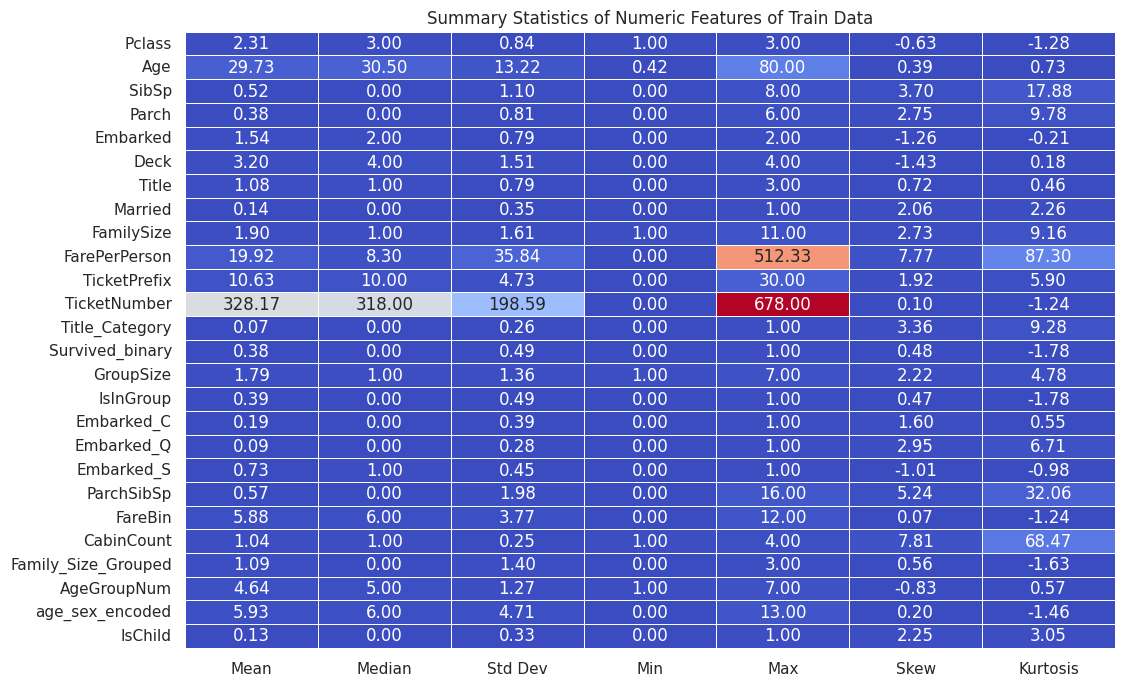

In [13]:
def log_transform(x):
    return np.log1p(x)

def sqrt_transform(x):
    return np.sqrt(x)

def plot_distributions(original_df, transformed_df, features, title_prefix):
    for feature in features:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Original data
        sns.histplot(original_df[feature].dropna(), kde=True, ax=axes[0])
        axes[0].set_title(f'{title_prefix} - Original {feature}')
        axes[0].text(1.02, 0.6, f"Mean: {original_df[feature].mean():.2f}\n"
                                f"Median: {original_df[feature].median():.2f}\n"
                                f"Std: {original_df[feature].std():.2f}\n"
                                f"Skew: {skew(original_df[feature].dropna()):.2f}\n"
                                f"Kurtosis: {kurtosis(original_df[feature].dropna()):.2f}",
                                transform=axes[0].transAxes)

        # Transformed data
        sns.histplot(transformed_df[feature].dropna(), kde=True, ax=axes[1])
        axes[1].set_title(f'{title_prefix} - Transformed {feature}')
        axes[1].text(1.02, 0.6, f"Mean: {transformed_df[feature].mean():.2f}\n"
                                f"Median: {transformed_df[feature].median():.2f}\n"
                                f"Std: {transformed_df[feature].std():.2f}\n"
                                f"Skew: {skew(transformed_df[feature].dropna()):.2f}\n"
                                f"Kurtosis: {kurtosis(transformed_df[feature].dropna()):.2f}",
                                transform=axes[1].transAxes)

        plt.tight_layout()
        plt.show()

def transform_and_plot(train_df, test_df, verbose=1):
    numerical_features = ['Age','FarePerPerson', 'TicketNumber'] 

    # Copy original data for plotting
    original_train = train_df[numerical_features].copy()

    # Initialize transformers
    transformers = {
        'Age': StandardScaler(),
        'FarePerPerson': log_transform,
        'TicketNumber': QuantileTransformer(output_distribution='normal'),
    }

    # Apply the transformations to train data
    for feature, transformer in transformers.items():
        if feature in ['FarePerPerson']:
            train_df[feature] = transformer(train_df[feature])
        else:
            train_df[feature] = transformer.fit_transform(train_df[[feature]])

    # Apply the same transformations to test data
    for feature, transformer in transformers.items():
        if feature in ['FarePerPerson']:
            test_df[feature] = transformer(test_df[feature])
        else:
            test_df[feature] = transformer.transform(test_df[[feature]])

    if verbose:
        plot_distributions(original_train, train_df, numerical_features, 'Train Data')

    return train_df, test_df

# Apply transformations and plot
# train_encoded, test_encoded = transform_and_plot(train_encoded, test_encoded, verbose=1)
visualize_data_analysis(train_encoded, "Train Data", [3, 4])


## 8. Creating Survival Rate Features
We create new features that represent the survival rate based on the family name and ticket number. This can help improve the model's prediction accuracy by providing additional context on survival probabilities.

### 8.1 Family and Ticket Survival Rates
We calculate the survival rates for families and tickets that appear in both the training and test datasets. This provides a survival probability based on the family name and ticket number, which can be a strong predictor of individual survival.

### 8.2 Combining Family and Ticket Survival Rates
We create new features by combining family and ticket survival rates. This provides a more comprehensive survival rate feature that captures both family and ticket information.

In [14]:

# Function to extract family surname
def extract_surname(name):
    if '(' in name:
        name_no_bracket = name.split('(')[0]
    else:
        name_no_bracket = name
    family = name_no_bracket.split(',')[0].strip()
    return ''.join([c for c in family if c not in string.punctuation])

# Function to add family and ticket survival rates
def add_survival_rates(combine):
    for df in combine:
        df['Family'] = df['Name'].apply(extract_surname)
        df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')
    
    df_train = combine[0]
    df_test = combine[1]

    non_unique_families = set(df_train['Family']).intersection(set(df_test['Family']))
    non_unique_tickets = set(df_train['Ticket']).intersection(set(df_test['Ticket']))
    
    family_rates = df_train.groupby('Family')['Survived_binary'].median()
    ticket_rates = df_train.groupby('Ticket')['Survived_binary'].median()
    
    mean_survival_rate = df_train['Survived_binary'].mean()
    
    for df in combine:
        df['Family_Survival_Rate'] = df['Family'].apply(lambda x: family_rates[x] if x in non_unique_families else mean_survival_rate)
        df['Ticket_Survival_Rate'] = df['Ticket'].apply(lambda x: ticket_rates[x] if x in non_unique_tickets else mean_survival_rate)
        df['Family_Survival_Rate_NA'] = df['Family'].apply(lambda x: 1 if x in non_unique_families else 0)
        df['Ticket_Survival_Rate_NA'] = df['Ticket'].apply(lambda x: 1 if x in non_unique_tickets else 0)
        df['Survival_Rate'] = (df['Family_Survival_Rate'] + df['Ticket_Survival_Rate']) / 2
        df['Survival_Rate_NA'] = (df['Family_Survival_Rate_NA'] + df['Ticket_Survival_Rate_NA']) / 2
    
    columns_to_drop = ['Family_Survival_Rate', 'Ticket_Survival_Rate', 
                       'Family_Survival_Rate_NA', 'Ticket_Survival_Rate_NA','Ticket_Frequency']
    
    for df in combine:
        df.drop(columns=columns_to_drop, errors='ignore', inplace=True)
    
    return combine

# Combine train and test datasets
combine = [train_encoded, test_encoded]

# Apply the function to add and drop survival rates
# combine = add_survival_rates(combine)

# Unpack the combine list back to train_encoded and test_encoded
train_encoded, test_encoded = combine



## 9. Apply SMOTE-Tomek and Train Model
We apply SMOTE-Tomek to handle class imbalance and train a Random Forest model with hyperparameter tuning.

### 9.1 Feature Selection for Survival Prediction Using MI

In [15]:
def select_survival_features(X, y, plot=True):
    # Select only numeric features
    X_numeric = X.select_dtypes(include=[np.number])
    
    # Calculate mutual information scores
    mi = mutual_info_classif(X_numeric, y)
    mi_series = pd.Series(mi, index=X_numeric.columns)
    sorted_mi_series = mi_series.sort_values(ascending=False)
    
    # Plot mutual information scores
    if plot:
        plt.figure(figsize=(10, 6))
        sorted_mi_series.plot(kind='bar')
        plt.title('Mutual Information of Features with Survival')
        plt.xlabel('Features')
        plt.ylabel('Mutual Information Score')
        plt.show()
    
    # Evaluate model performance with different numbers of top features
    scores = []
    num_features_range = range(5, 15)
    for num in num_features_range:
        selected_features = sorted_mi_series.index[:num]
        X_selected = X_numeric[selected_features]
        dt = RandomForestClassifier(random_state=42)
        cv_scores = cross_val_score(dt, X_selected, y, cv=5, scoring='accuracy')
        scores.append(cv_scores.mean())
    
    # Plot the model performance
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_range, scores, marker='o')
    plt.title('Model Performance vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    # Find the optimal number of features
    optimal_num_features = num_features_range[scores.index(max(scores))]
    print(f"Optimal number of features: {optimal_num_features}")
    return sorted_mi_series.index[:optimal_num_features].tolist()


### 9.2 Training the Random Forest Model


In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(X, y):
    param_dist = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [10, 15, 20, 25],
        'min_samples_split': [8, 12, 16, 20],
        'min_samples_leaf': [4, 8, 12, 16],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    random_search = RandomizedSearchCV(
        RandomForestClassifier(random_state=42),
        param_distributions=param_dist,
        n_iter=50,
        cv=5,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X, y)
    
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best accuracy: {random_search.best_score_}")
    
    return random_search.best_estimator_


### 9.3 Applying SMOTE-Tomek


In [17]:
def apply_smote_tomek(X, y, sampling_strategy=0.75):
    smote_tomek = SMOTETomek(sampling_strategy=sampling_strategy, random_state=42)
    X_res, y_res = smote_tomek.fit_resample(X, y)
    return X_res, y_res


### 9.4 Model Evaluation


In [18]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    cr = classification_report(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
    roc_auc = auc(fpr, tpr)
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{cr}")
    print(f"Accuracy: {accuracy}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


### 9.5 Predict and Prepare Submission


In [19]:
def predict_and_prepare_submission(model, X_test, test, filename='submission_rf.csv'):
    predictions = model.predict(X_test)
    submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': predictions})
    submission['Survived'] = submission['Survived'].map({1: 'T', 0: 'F'})
    submission.to_csv(filename, index=False)
    print(f"Submission file '{filename}' created.")


### 9.6 Integrate All methods


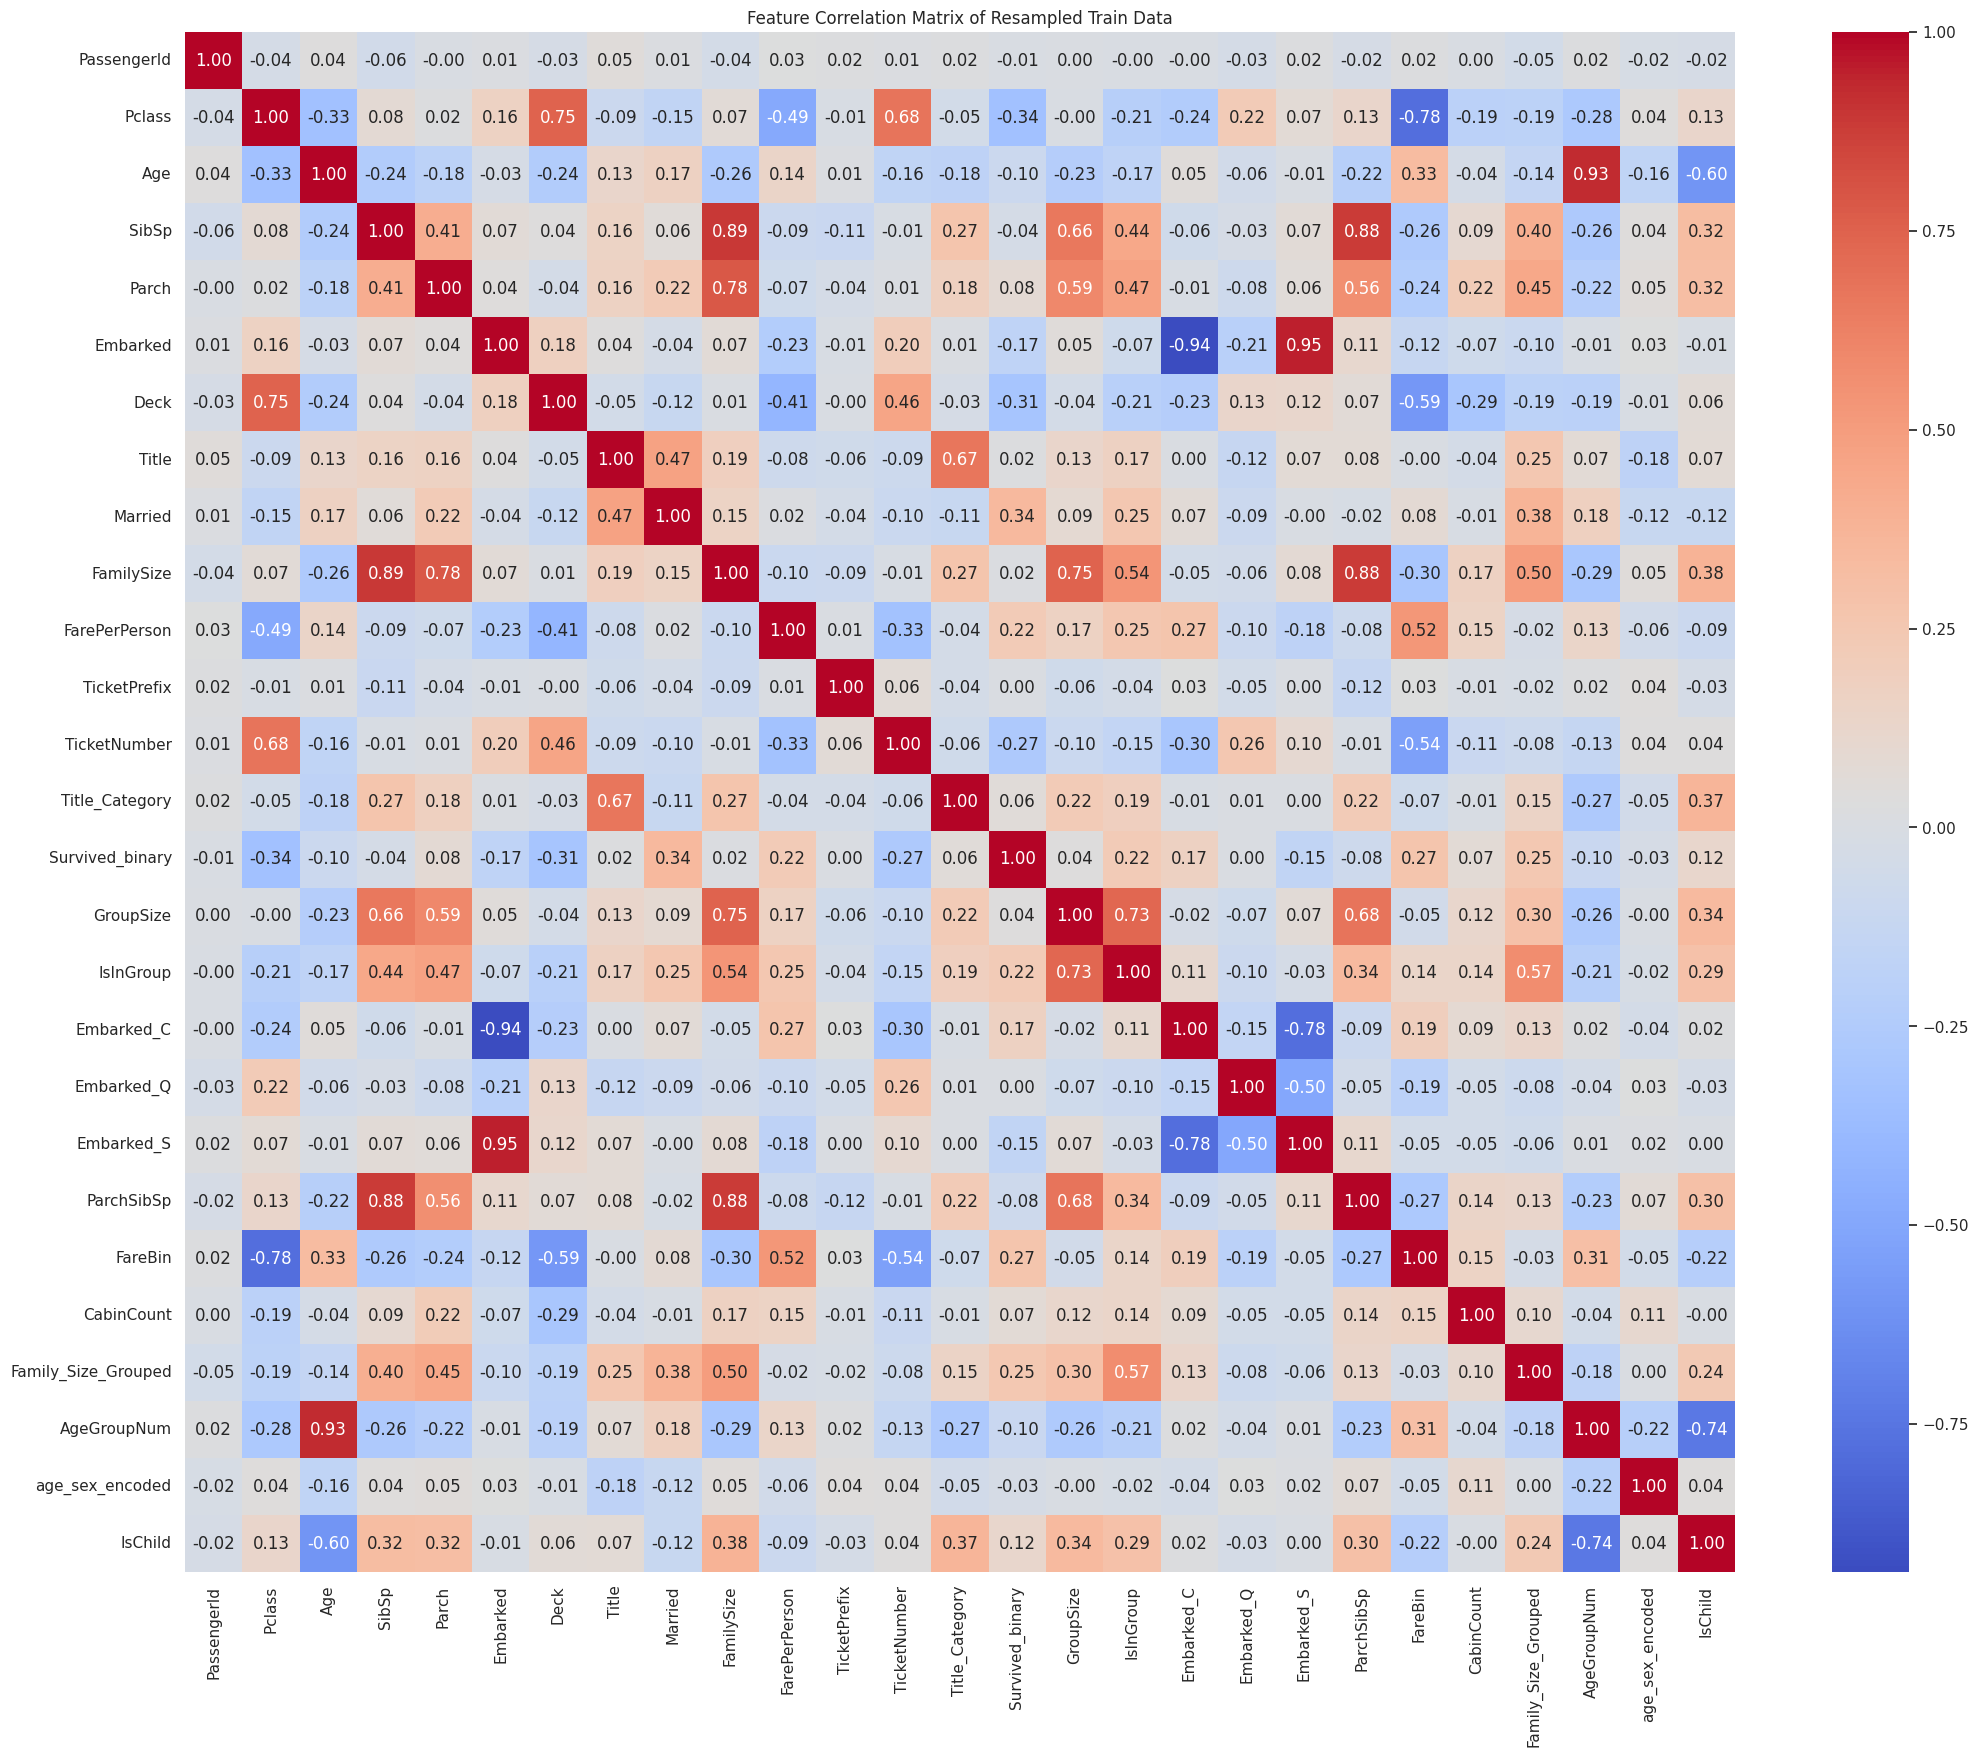

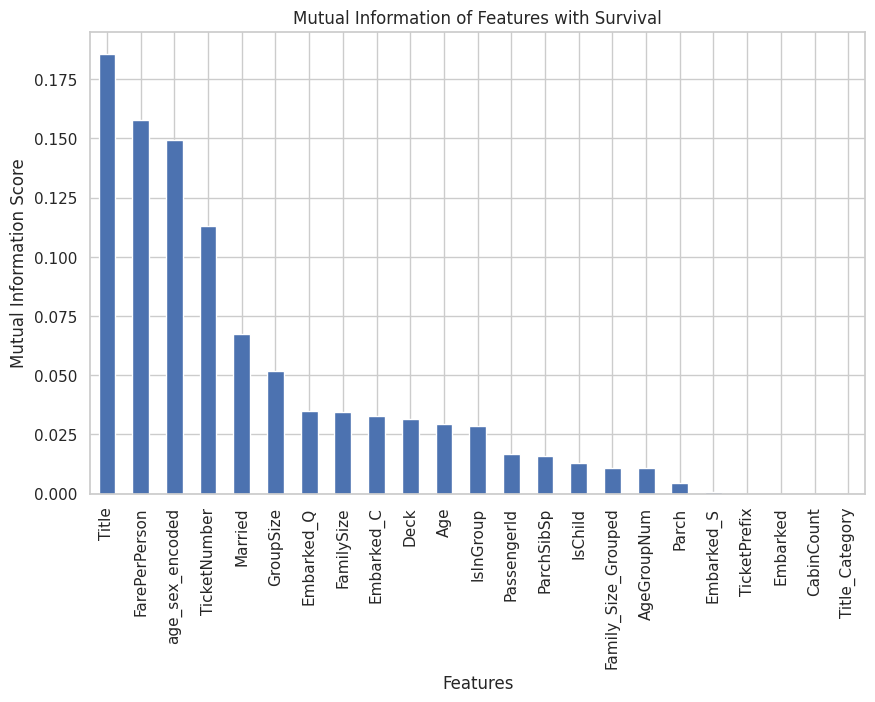

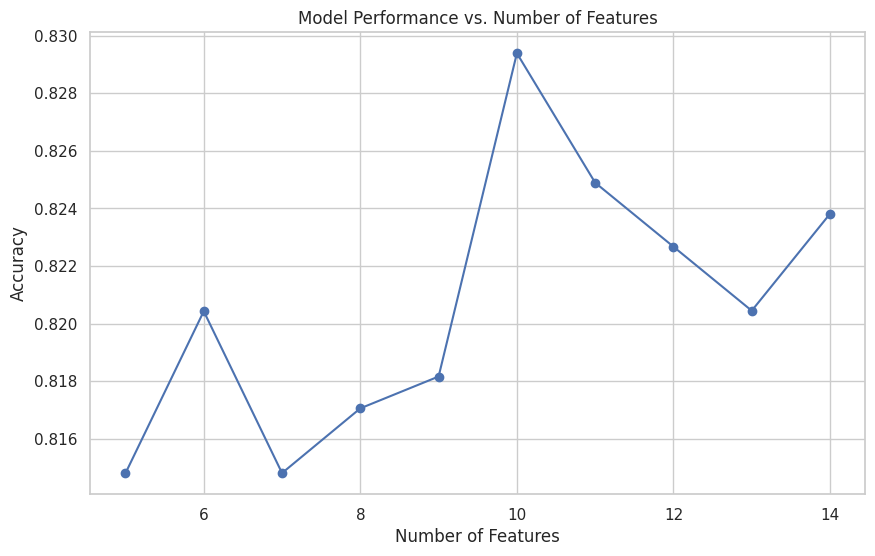

Optimal number of features: 10
Best parameters: {'n_estimators': 100, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 25, 'bootstrap': False}
Best accuracy: 0.827710843373494
Submission file 'submission_rf.csv' created.


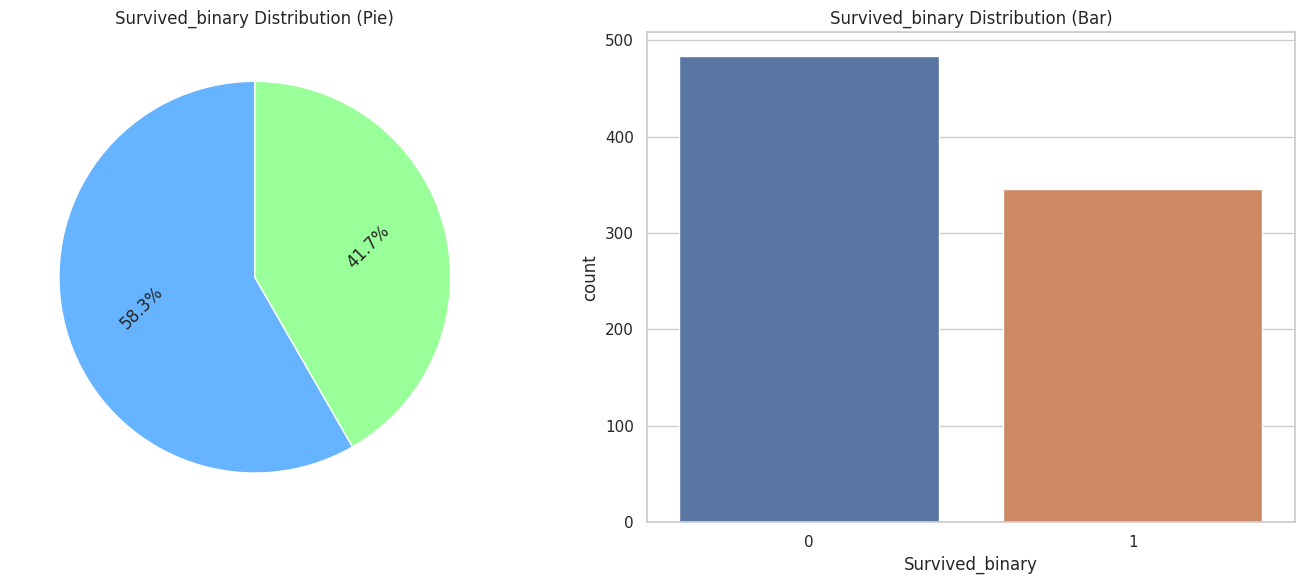

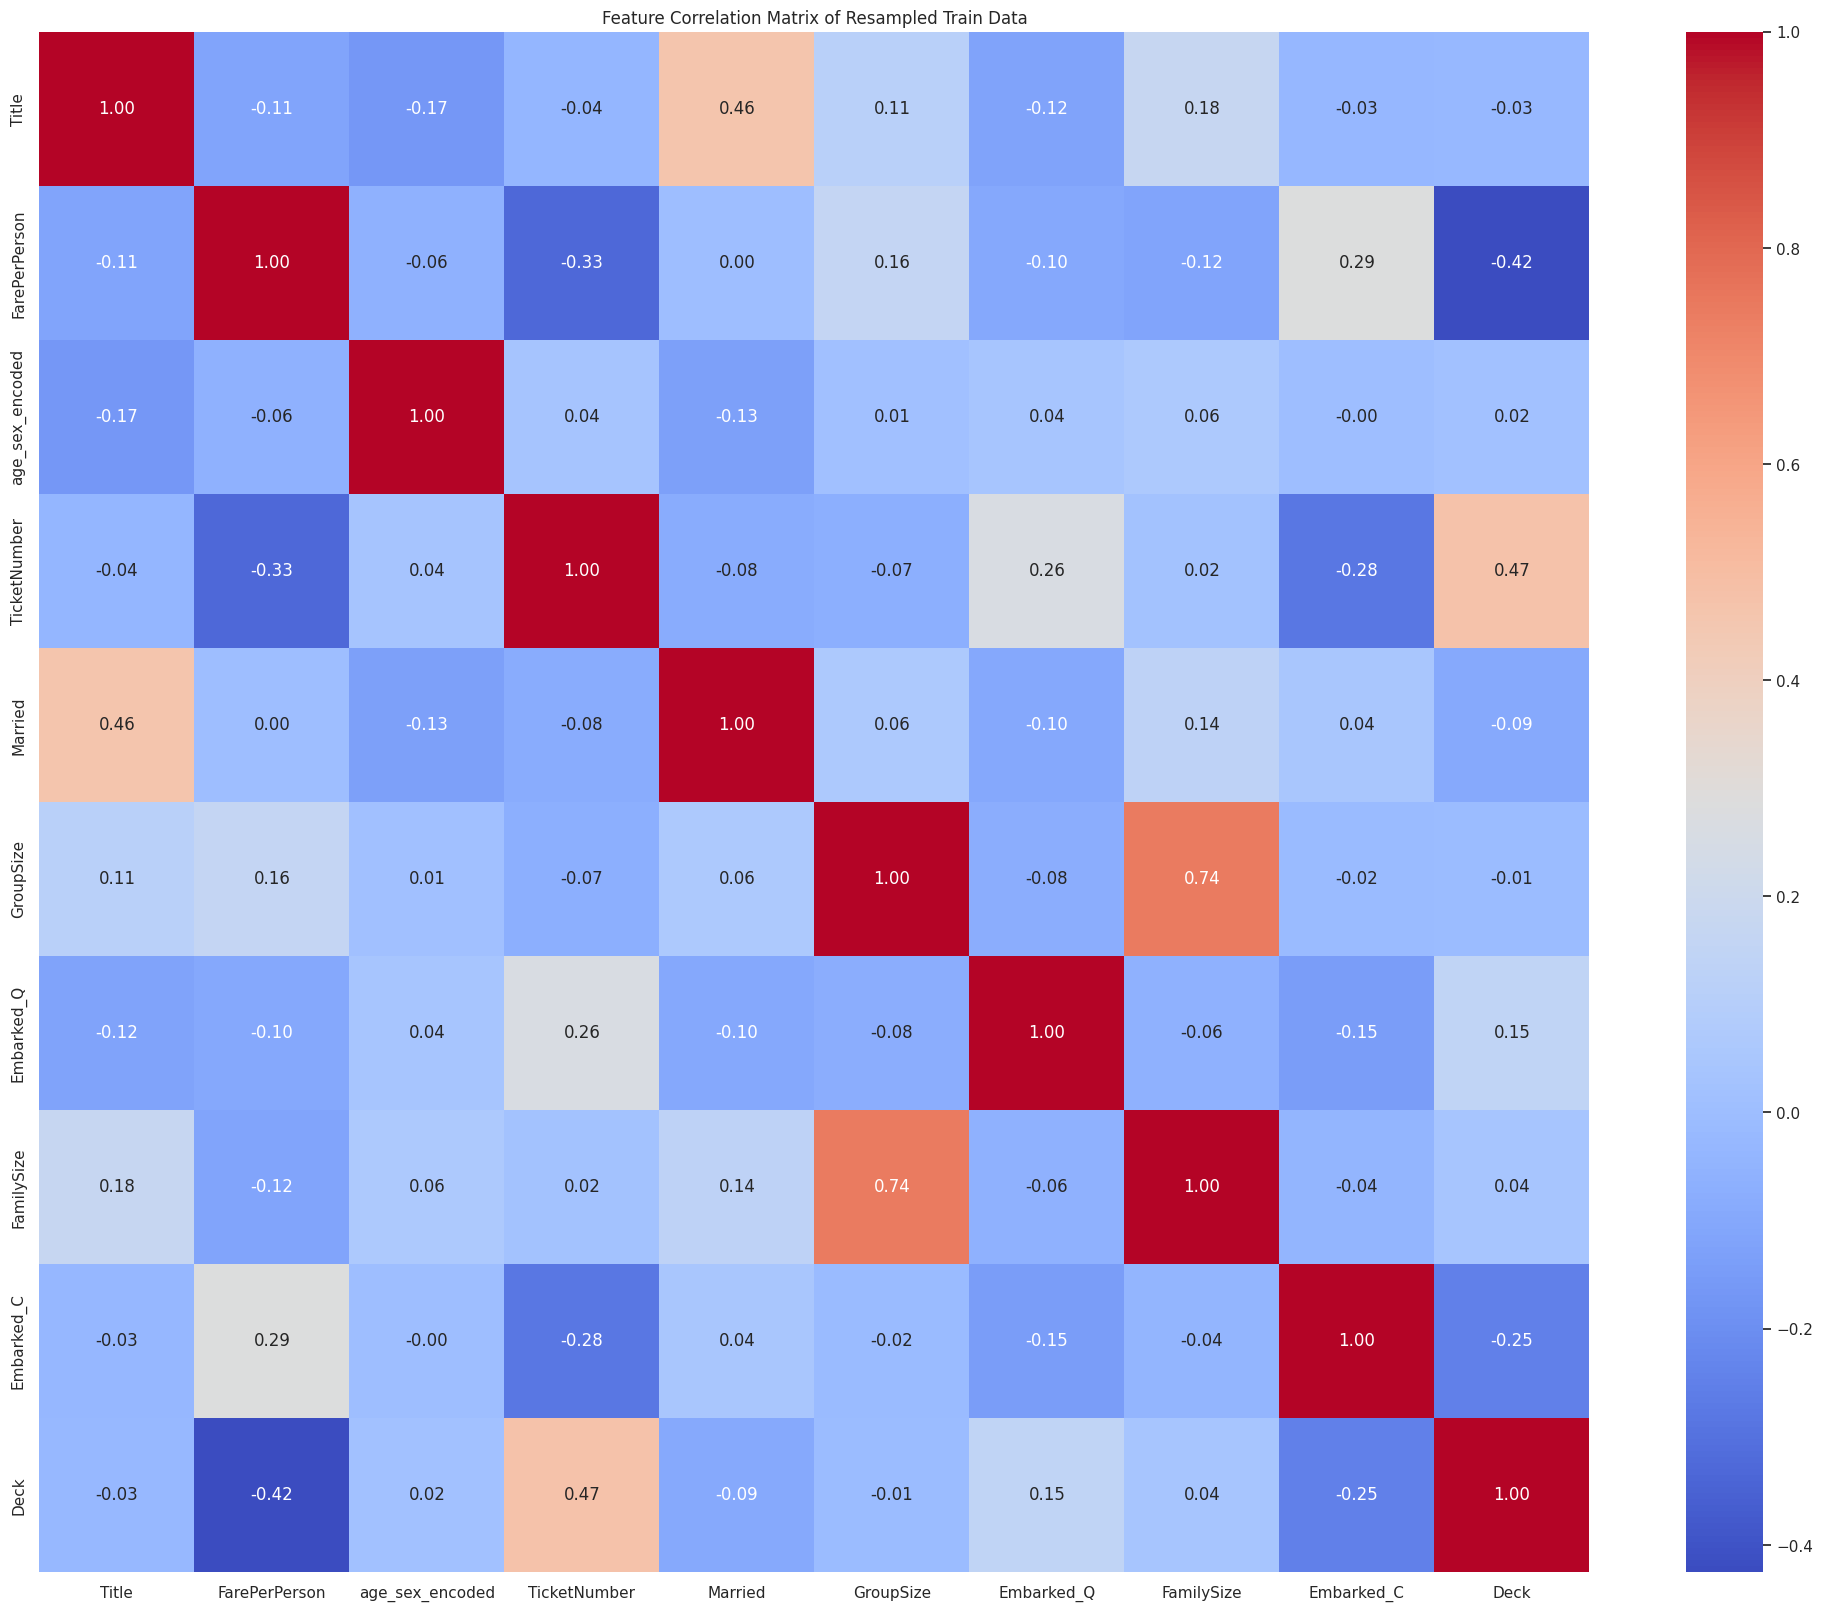

In [20]:
visualize_data_analysis(train_encoded, "Resampled Train Data", [3], ['Survived_binary'])


# Separate features and target variable from training data
X_train = train_encoded.drop(columns=['Survived', 'Survived_binary'])
#high correlated feature to more Important features
# X_train = X_train.drop(columns=['FareBin','GroupSize','TicketNumber','Pclass','Deck','Deck_U','Deck_ABC','IsInGroup','Married','Parch','Title_Category'])
X_train = X_train.drop(columns=['FareBin','Pclass','SibSp'])
y_train = train_encoded['Survived_binary']

# Select best features for survival prediction using MI
selected_survival_features = select_survival_features(X_train, y_train)
X_train_selected = X_train[selected_survival_features]

# Apply SMOTE to handle class imbalance + TOMEK to toss noisy data
X_train_resampled, y_train_resampled = apply_smote_tomek(X_train_selected, y_train)

# Train and tune the Random Forest classifier
best_rf = train_random_forest(X_train_resampled, y_train_resampled)

# Prepare test data for prediction
X_test = test_encoded[selected_survival_features]

# Predict and prepare the submission file
predict_and_prepare_submission(best_rf, X_test, test)

# Convert y_train_resampled to DataFrame to use visualize_data_analysis function
y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['Survived_binary'])

# Visualize the class distribution
visualize_data_analysis(y_train_resampled_df, "Resampled Train Data", [5], ['Survived_binary'])
visualize_data_analysis(X_train_resampled, "Resampled Train Data", [3], ['Survived_binary'])




## 10. K-fold Cross Validation and Learning Curve


Confusion Matrix:
[[463  21]
 [ 41 305]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       484
           1       0.94      0.88      0.91       346

    accuracy                           0.93       830
   macro avg       0.93      0.92      0.92       830
weighted avg       0.93      0.93      0.92       830

Accuracy: 0.9253012048192771


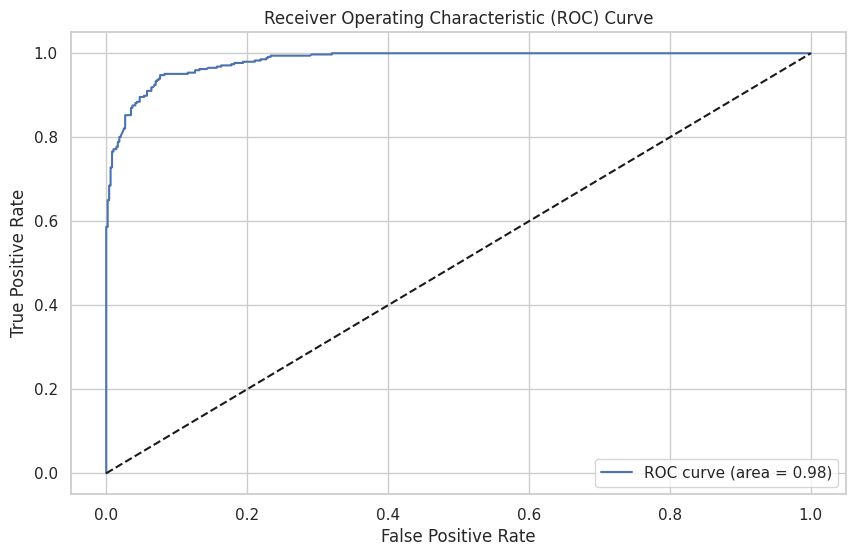

Cross-validation scores for k=4: [0.82211538 0.82692308 0.83091787 0.82125604]

Mean cross-validation score for k=4: 0.83

Standard deviation of cross-validation scores for k=4: 0.0
Cross-validation scores for k=5: [0.84939759 0.8373494  0.84337349 0.8313253  0.8253012 ]

Mean cross-validation score for k=5: 0.84

Standard deviation of cross-validation scores for k=5: 0.01
Cross-validation scores for k=6: [0.82014388 0.84172662 0.84782609 0.81884058 0.81884058 0.83333333]

Mean cross-validation score for k=6: 0.83

Standard deviation of cross-validation scores for k=6: 0.01
Cross-validation scores for k=7: [0.8487395  0.85714286 0.83193277 0.86554622 0.81355932 0.86440678
 0.79661017]

Mean cross-validation score for k=7: 0.84

Standard deviation of cross-validation scores for k=7: 0.02
Cross-validation scores for k=8: [0.83653846 0.83653846 0.82692308 0.875      0.84615385 0.84615385
 0.82524272 0.80582524]

Mean cross-validation score for k=8: 0.84

Standard deviation of cross-valida

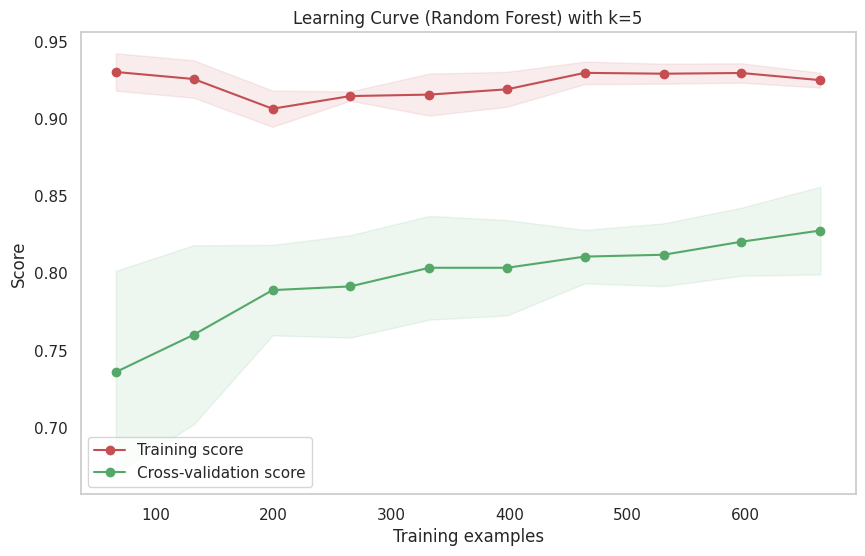

In [21]:
def kfold_cross_validation(model, X, y, k_values=range(4, 9)):
    best_k = None
    best_score = -np.inf
    best_cross_val_scores = None

    for k in k_values:
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        cross_val_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
        mean_score = np.mean(cross_val_scores).round(2)
        std_score = np.std(cross_val_scores).round(2)

        print(f"Cross-validation scores for k={k}: {cross_val_scores}\n")
        print(f"Mean cross-validation score for k={k}: {mean_score}\n")
        print(f"Standard deviation of cross-validation scores for k={k}: {std_score}")

        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            best_std = std_score
            best_cross_val_scores = cross_val_scores

    print(f"Best k: {best_k} \n")
    print(f"Best mean cross-validation score: {best_score}\n")
    print(f"Standard deviation of the best cross-validation scores: {best_std} \n\n\n")

    return best_k, best_cross_val_scores

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Evaluate the model by ROC and confusion matrix
evaluate_model(best_rf, X_train_resampled, y_train_resampled)

# Plot the learning curve
best_k, _ = kfold_cross_validation(best_rf, X_train_resampled, y_train_resampled)
plot_learning_curve(best_rf, f"Learning Curve (Random Forest) with k={best_k}", X_train_resampled, y_train_resampled, cv=best_k)
plt.show()